Sta 663 - Statistical Computing and Computation - Project Madness
-----------
Alison Reynolds, Emma Schmidt, Nick Dahl


## Task 0 - Code and Library Setup

In [1]:
# Load necessary packages
import math
import numpy as np
import pandas as pd
import sklearn 
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for learning models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Packages for handling warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## Task 1 - Exploration and Feature Construction

For our group's final project, we have opted to use data from the outcomes of previous renditions of the NCAA Men's Basketball "March Madness", a regularly held tournament which pits the best 68 teams in the nation against each other in a head-to-head, single elimination competition. Four games are played in an initial "play-in" style tournament, then a standard 64-team bracket including the winners proceeds, whittling down the remaining teams by half until a single collegiate team is crowned victor. Predicting game outcomes requires several stages of data analysis, concatenation, cleaning, and modeling, the results of which have been compiled into our final submission below. Our primary data files come from this year's Kaggle competition (https://www.kaggle.com/competitions/mens-march-mania-2022/data), out of which we selected a subset to consider more intensely. In particular, we elected to gather data from the regular season's detailed results for Division I games and from the Massey Index documentation.

#### Data Description

During every season, there are thousands of regular season basketball games competed within the NCAA's Division I category, each of which comes complete with a full set of summary statistics describing outcome, team performance, and key execution attributes such as rebounds, 3-pointers, shooting percentage, and blocks. Throughout the season, teams are also regularly ranked in national polls, several of which are aggregated into the Massey Index, a summary statistic describing national sentiment regarding the performance, trajectory, and ordinal comparison of Division I teams. These same statistics carry into a parallel document which provides the performances of different teams in tournaments of the past, documenting each of their successful runs and how many games they advanced.

In addition to these default data regarding game outcomes and performance statistics, we also investigated the creation of additional features, which were intended to create a signal regarding general temporal trends (i.e., whether a team was "hot" coming into the tournament and had been rising in standings, or whether they were plummeting due to key late-season losses). Because rankings are based not exclusively on in-season performance but also on strength of schedule, program history, and other general biases, we figured that these features might highlight the underlying trends in team's performances. Then, we also gave consideration to whether games were played in the regular season or tournament, under the assumption that high pressure, single-elimination games might cause some teams to faulter and others to excel.

#### Goals of Analysis

With our analysis, we sought to clean and create an effective training and test set based on recent games, then to translate this data into several models. To evaluate our best performing model's validity, we set up several parametric simulations based on historical data and chance, which operated without access to any game play data, flipping a coin to determine the winner of each game. The most intuitive of these simulations, our "blind luck" approach which used a fair coin, was meant to set a lower bound for acceptable performance of any subsequent model. We then proceeded with the "plain vanilla" model, only taking the average win statistics of each ranked position against other ranked positions in the tournament and simulating outcomes. This represented the minimally informed approach, using the seeded positions to simulate an outcome, then determining its average success without any regard for particular features of the incoming teams. Using a large volume of trials, this model gave us percentage chances of wins from each team that would be used to generate an estimated outcome bracket for the recently concluded 2022 iteration of March Madness. 

When exploring models, we attempted several approaches:

- Linear Regression
- AdaBoost Regressor (with K-Fold Validation)
- Ridge Regression with K-Fold Validation
- Random Forest 
    - Full data, full feature set
    - Averaged data, full feature set
    - Averaged data, restricted feature set
    - Averaged data, predicting tournament wins

To start below, we will create each of the necessary features from the data:

In [2]:
# Read in the Massey Index Data
msy = pd.read_csv('data/MMasseyOrdinals_thruDay128.csv')

In [3]:
# Generate the dictionary
mdict = {}
# Range over different seasons for unique values
szn_range =  msy.Season.unique()
# Iterate through each
for szn in szn_range:
    # Initialize
    mdict[szn] = {}
    msy_szn = msy[msy["Season"]==szn]
    # Get unique Team ID values
    lst_tms_szn = msy_szn.TeamID.unique()
    rnk_day = msy_szn.RankingDayNum
    # Create quantile ranks for day of season
    q01_rnk_day_szn = rnk_day.quantile(.01)
    q1_rnk_day_szn = rnk_day.quantile(0.25)
    q2_rnk_day_szn = rnk_day.quantile(.50)
    q3_rnk_day_szn = rnk_day.quantile(0.75)
    q90_rnk_day_szn = rnk_day.quantile(.9)
    
    # Iterate through each team
    for team in lst_tms_szn:
        # Add a new entry
        msy_szn_tms = msy_szn[msy_szn["TeamID"]==team]
        mdict[szn][team] = {}
        
        # Create value for average team ranking
        mdict[szn][team]["Avg Ranking"] = msy_szn_tms["OrdinalRank"].mean()
        
        # Create several time lag intermediate rankings
        mdict[szn][team]["Begin Ranking"] = msy_szn_tms[msy_szn_tms["RankingDayNum"]<q01_rnk_day_szn]["OrdinalRank"].mean()
        mdict[szn][team]["Early Ranking"] = msy_szn_tms[msy_szn_tms["RankingDayNum"]<q1_rnk_day_szn]["OrdinalRank"].mean()
        mdict[szn][team]["Early Median Ranking"] = msy_szn_tms[(msy_szn_tms["RankingDayNum"]>=q1_rnk_day_szn) & (msy_szn_tms["RankingDayNum"]<=q2_rnk_day_szn)]["OrdinalRank"].mean()
        mdict[szn][team]["Late Median Ranking"] = msy_szn_tms[(msy_szn_tms["RankingDayNum"]>=q2_rnk_day_szn) & (msy_szn_tms["RankingDayNum"]<=q3_rnk_day_szn)]["OrdinalRank"].mean()
        mdict[szn][team]["Late Ranking"] = msy_szn_tms[msy_szn_tms["RankingDayNum"]>q3_rnk_day_szn]["OrdinalRank"].mean()
        mdict[szn][team]["End Ranking"] = msy_szn_tms[msy_szn_tms["RankingDayNum"]>q90_rnk_day_szn]["OrdinalRank"].mean()
        
        # Create rank trajectories for season
        mdict[szn][team]["Rank Trajectory - Early"] = - (mdict[szn][team]["Early Median Ranking"] - mdict[szn][team]["Early Ranking"])
        mdict[szn][team]["Rank Trajectory - Late"] =  - (mdict[szn][team]["Late Ranking"] - mdict[szn][team]["Late Median Ranking"])
        mdict[szn][team]["Rank Trajectory - Total"] =  - (mdict[szn][team]["End Ranking"] - mdict[szn][team]["Begin Ranking"])

# Alternately, store as a data frame for merging features later
df_msy = pd.DataFrame(columns=["Season", "Team ID", "Avg Ranking", "Begin Ranking", "Early Ranking", "Early Median Ranking","Late Median Ranking", "Late Ranking", "End Ranking", "Rank Trajectory - Early", "Rank Trajectory - Late", "Rank Trajectory - Total"])
for season in mdict.keys():
    for team in mdict[season].keys():
        # Store by Season/Team ID
        dict_season_team = mdict[season][team]
        dict_season_team["Season"]=season
        dict_season_team["Team ID"]=team
        df_msy = df_msy.append(dict_season_team, ignore_index=True)

In [4]:
# Season: 2003, Team: 1107 statistics
mdict[2003][1107]

{'Avg Ranking': 291.9875,
 'Begin Ranking': 249.0,
 'Early Ranking': 269.6951219512195,
 'Early Median Ranking': 294.421875,
 'Late Median Ranking': 298.75,
 'Late Ranking': 301.18947368421055,
 'End Ranking': 301.37142857142857,
 'Rank Trajectory - Early': -24.726753048780495,
 'Rank Trajectory - Late': -2.4394736842105544,
 'Rank Trajectory - Total': -52.37142857142857,
 'Season': 2003,
 'Team ID': 1107}

In [5]:
# What does the full data look like?
df_msy

,Season,Team ID,Avg Ranking,Begin Ranking,Early Ranking,Early Median Ranking,Late Median Ranking,Late Ranking,End Ranking,Rank Trajectory - Early,Rank Trajectory - Late,Rank Trajectory - Total
0,2003.0,1102.0,144.287500,159.0,129.182927,136.179688,149.691667,158.357895,157.228571,-6.996761,-8.666228,1.771429
1,2003.0,1103.0,182.205000,229.0,199.207317,185.656250,182.491667,162.694737,168.314286,13.551067,19.796930,60.685714
2,2003.0,1104.0,27.655502,12.0,17.233333,23.971014,35.295082,33.642105,38.114286,-6.737681,1.652977,-26.114286
3,2003.0,1105.0,305.377500,314.0,291.268293,306.632812,312.466667,308.842105,308.342857,-15.364520,3.624561,5.657143
4,2003.0,1106.0,243.265000,260.0,252.317073,229.921875,235.875000,258.326316,259.428571,22.395198,-22.451316,0.571429
...,...,...,...,...,...,...,...,...,...,...,...,...
6897,2022.0,1468.0,206.520604,NaN,223.833333,216.555046,185.693396,197.351190,188.315789,7.278287,-11.657794,NaN
6898,2022.0,1469.0,271.579670,NaN,275.055556,280.096330,267.929245,260.916667,268.245614,-5.040775,7.012579,NaN
6899,2022.0,1470.0,220.846154,NaN,246.094444,208.169725,212.250000,220.178571,225.052632,37.924720,-7.928571,NaN
6900,2022.0,1471.0,238.221154,NaN,190.527778,238.577982,264.292453,262.398810,262.368421,-48.050204,1.893643,NaN


The above code creates the Massey Index Lag Variables:
- Avg Ranking: the average positional ranking for each team in a given season over the entire regular season's duration
- Begin Ranking: the position each team began the season ranked as, if they were ranked. Otherwise, it takes NaN as a value
- Early Ranking: the rank for a team in the first quarter of a season
- Early Median Ranking: the rank for a team in the second quarter of a season
- Late Median Ranking: the rank for a team in the third quarter of a season
- Late Ranking: the rank for a team in the last quarter of a season
- Rank Trajectory - Early: the move in rank for a team during the first half of the season
- Rank Trajectory - Late: the move in rank for a team during the second half of the season
- Rank Trajectory - Total: the total season move in rank for a position, which takes NaN if a team was unranked either to start or end.

Next, we read in data on regular season results and standardized the outputs to create rows representing unique games:

In [6]:
# Read in data on teams and detailed regular season results
team = pd.read_csv('data/MTeams.csv')
season = pd.read_csv('data/MRegularSeasonDetailedResults.csv')
pd.options.mode.chained_assignment = None

# Save information for both winners and losers
winners = season[['Season', 'DayNum', 'WTeamID', 'WScore', 'WLoc','NumOT', 
                 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 
                 'WDR','WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LScore']]
losers = season[['Season', 'DayNum', 'LTeamID', 'LScore','NumOT','LFGM', 
                 'LFGA', 'LFGM3', 'LFGA3','LFTM', 'LFTA', 'LOR', 'LDR', 
                 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 'WScore']]

# Rename for points allowed
winners.rename({'LScore':'PtsAllowed'},axis = 1,inplace=True)
losers.rename({'WScore':'PtsAllowed'},axis = 1,inplace=True)

# Change column names
winners.columns = winners.columns.str.replace(r'^W', '',regex=True)
losers.columns = losers.columns.str.replace(r'^L', '',regex=True)

# Create indicator variable for whether a team won a game
winners["Win"] = 1
losers["Win"] = 0

# Combine all of the features into a single data frame
total = pd.concat([winners, losers], axis=0)
total = total.merge(team, left_on='TeamID', right_on='TeamID')

# total possesions = field goals attempted - offensive rebounds + turnovers + (0.4 x free throws attempted)  
# offensive efficiency = total points / total possesions  
# defensive efficiency = total points allowed / total possesions
total["OffEff"] = total["Score"]/(total["FGA"] - total["OR"] + total["TO"] + (.4 * total["FTA"]))
total["DefEff"] = total["PtsAllowed"] / (total["FGA"] - total["OR"] + total["TO"] + (.4 * total["FTA"]))

In [7]:
# Examine the features from cleaned data and dimensionality
total

,Season,DayNum,TeamID,Score,Loc,NumOT,FGM,FGA,FGM3,FGA3,...,Stl,Blk,PF,PtsAllowed,Win,TeamName,FirstD1Season,LastD1Season,OffEff,DefEff
0,2003,10,1104,68,N,0,27,58,3,14,...,7,1,22,62,1,Alabama,1985,2022,0.916442,0.835580
1,2003,18,1104,82,H,0,24,49,10,20,...,7,3,14,56,1,Alabama,1985,2022,1.289308,0.880503
2,2003,21,1104,80,H,0,27,59,8,24,...,10,6,13,65,1,Alabama,1985,2022,1.123596,0.912921
3,2003,25,1104,54,N,0,16,57,7,25,...,6,6,21,48,1,Alabama,1985,2022,0.879479,0.781759
4,2003,29,1104,89,H,0,34,70,9,22,...,10,4,17,61,1,Alabama,1985,2022,1.271429,0.871429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204059,2022,101,1472,70,NaN,0,26,60,7,24,...,9,0,17,78,0,St Thomas MN,2022,2022,1.076923,1.200000
204060,2022,103,1472,64,NaN,0,22,53,3,21,...,4,2,18,75,0,St Thomas MN,2022,2022,0.966767,1.132931
204061,2022,108,1472,60,NaN,0,22,59,9,34,...,6,0,20,81,0,St Thomas MN,2022,2022,0.928793,1.253870
204062,2022,110,1472,60,NaN,0,21,68,14,45,...,1,1,15,79,0,St Thomas MN,2022,2022,0.877193,1.154971


As we can see, we now have 204,064 rows, each with 26 columns of features, in a tidy format. Features are as follows:

- Score: the score of the winning team
- Loc: Either N (neutral location), H (home game), or A (away game)
- NumOT: The number of times the game went into extra periods due to a tie
- FGM: Field goals made
- FGA: Field goal attempts
- FGM3: The number of 3-point shots made during regulation
- FGA3: the number of attempted 3-point shots
- WFGA - field goals attempted (by the winning team)
- FTM - free throws made
- FTA - free throws attempted
- OR - offensive rebounds 
- DR - defensive rebounds 
- Ast - assists 
- TO - turnovers committed 
- Stl - steals accomplished
- Blk - blocks accomplished
- PF - personal fouls committed 
- Pts allowed: Points allowed to the opposing team
- FirstD1Season: the first time the team was listed as a Division I program
- LastD1Season: the last time a team was listed as a Division I program
- OffEff: offensive efficiency, equal to total points / total possesions  
- DefEff: defensive efficiency, equal to total points allowed / total possesions

To expand upon these, we are going to merge the two sets of features from the game statistics and the Massey Index to create our full set of cleaned data. This merge is performed along both the Season and TeamID columns, so that each observation gets all of the temporal lag features attached for the relevant season/team pairing:

In [8]:
# Merge the two datasets
total = pd.merge(total, df_msy,  how='left', left_on=['Season','TeamID'], right_on = ['Season','Team ID'])

Prior to proceeding with models, we can begin to analyze the set of features that we've now created through a simple Exploratory Data Analysis. With a few sets of visualizations, we aimed to identify which predictors might play an important role in the upcoming models. Our first visualization highlights the point differential between teams depending on whether they were at home ("H"), a neutral location ("N"), or an away game ("A"). We can see that teams win by a larger margin when playing at home, regardless of year.

In [9]:
# Read in data on teams and detailed tournament results
tourn_season = pd.read_csv('data/MNCAATourneyDetailedResults.csv')
pd.options.mode.chained_assignment = None

# Save information for both winners and losers
tourn_winners = tourn_season[['Season', 'DayNum', 'WTeamID']]
tourn_losers = tourn_season[['Season', 'DayNum', 'LTeamID']]

# Change column names
tourn_winners.columns = tourn_winners.columns.str.replace(r'^W', '',regex=True)
tourn_losers.columns = tourn_losers.columns.str.replace(r'^L', '',regex=True)

# Create indicator variable for whether a team won a game
tourn_winners["Win"] = 1
tourn_losers["Win"] = 0

# Combine all of the features into a single data frame
tourn_total = pd.concat([tourn_winners, tourn_losers], axis=0)
tourn_total = tourn_total.merge(team, left_on='TeamID', right_on='TeamID')
tourn_total = tourn_total.drop(['DayNum','FirstD1Season','LastD1Season'], axis = 1)
tourn_sum = tourn_total.groupby(['TeamID','Season']).sum()
tourn_sum.rename({'Win':'TournWins'},axis=1,inplace=True)

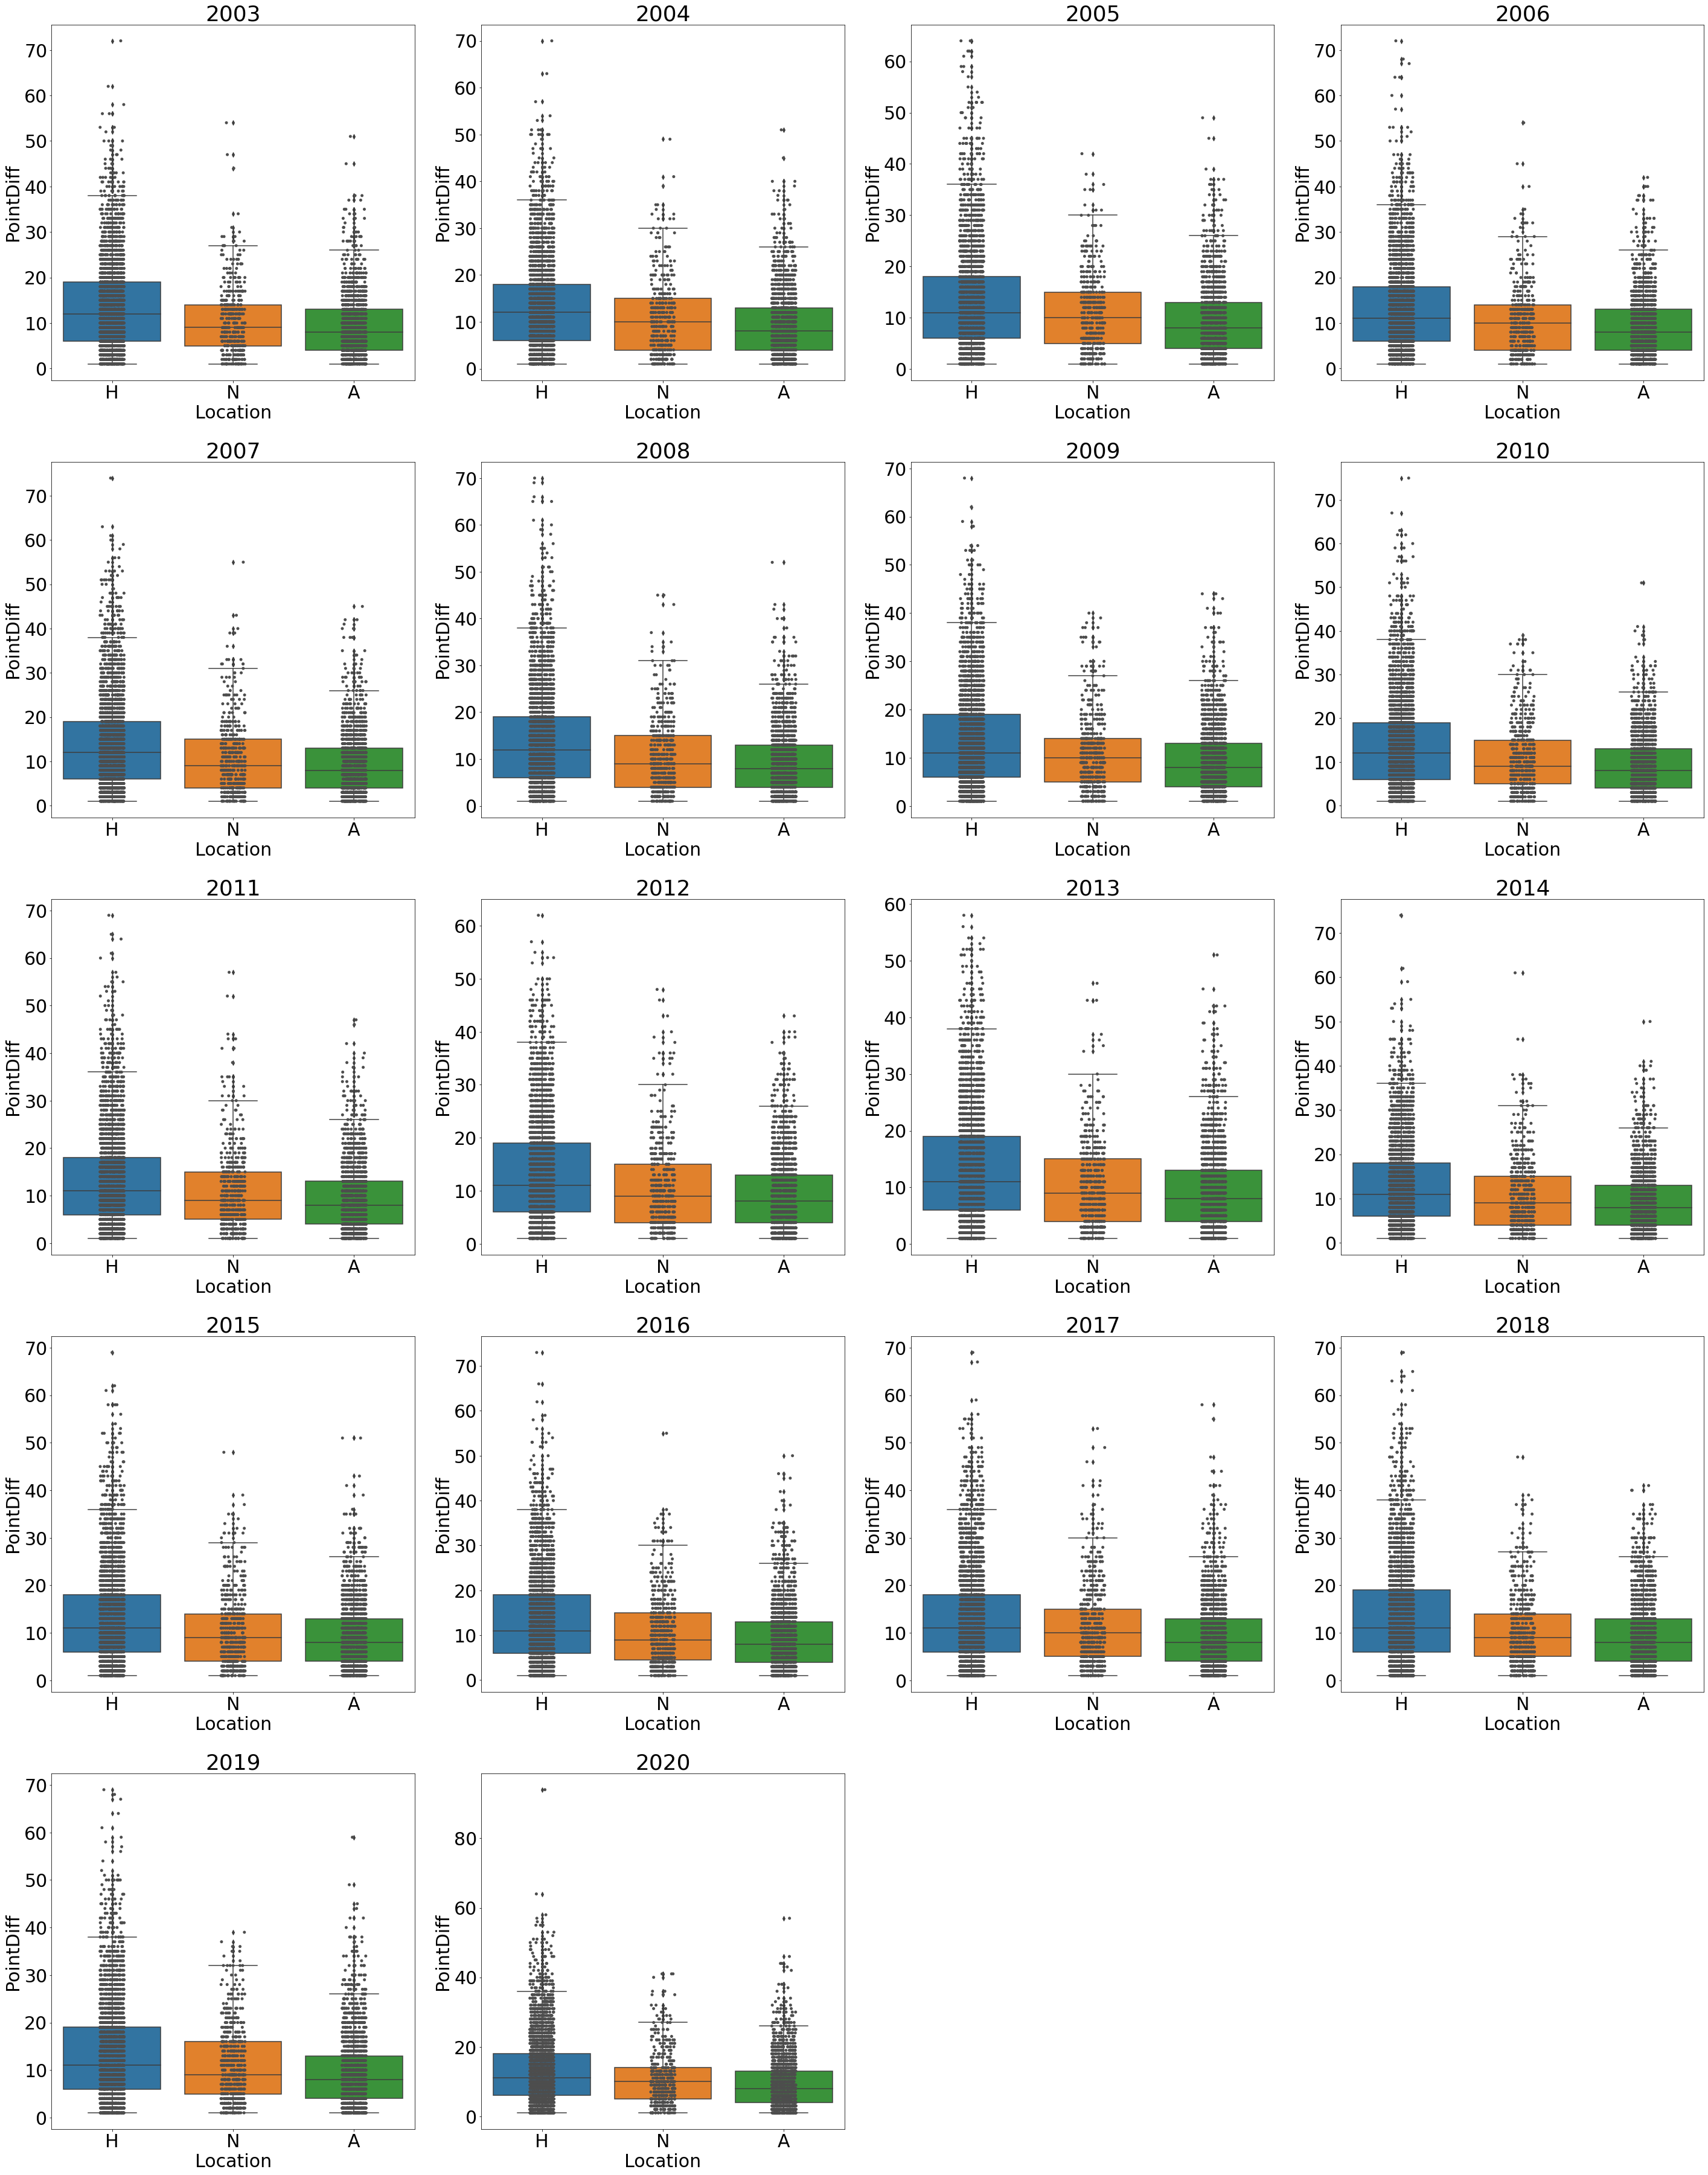

In [10]:
# Code to get layout by year from https://www.kaggle.com/code/masaishi/get-tournament-result-from-prediction
x = 4
y = int(36/x)
graphframe = pd.DataFrame(data={"Location": total['Loc'],"Season": total['Season'], "PointDiff": total['Score'] - total['PtsAllowed']})

# Set figure size
fig = plt.figure(figsize=(x*10, y*10))
plt.rcParams["font.size"] = 30

# Loop through each season
for i, season in enumerate(range(2003, 1985+x*y)):
    # Generate a subplot
    ax = fig.add_subplot(y, x, i+1)
    # Generate the boxplot
    sns.boxplot(data=graphframe[graphframe['Season']==season], 
                 x='Location', y='PointDiff', order=['H', 'N', 'A'], ax=ax)
    # Lay on top the strip plot
    sns.stripplot(data=graphframe[graphframe['Season']==season], 
                 x='Location', y='PointDiff', order=['H', 'N', 'A'], ax=ax, color='.3')
    # Set title by season
    ax.set_title(season)
# Display plots
fig.tight_layout()

The next visualization shows relative rate of blocks versus fouls, to see if there are trends regarding how aggressively a defense plays versus how likely they are to win. Teams that commit several fouls tend to generate more defensive turnovers, but also give the opposition more free throws at the line.

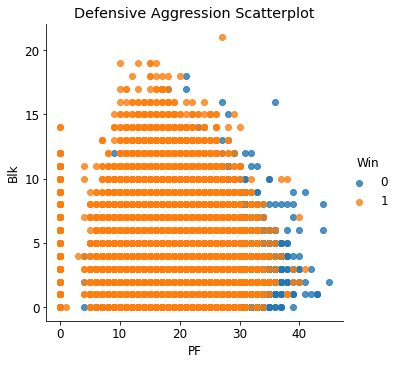

In [11]:
# Creat OFF/DEF Efficiency plot.
plt.rcParams["font.size"] = 12
sns.lmplot('PF', 'Blk', data=total, hue='Win', fit_reg=False)
plt.title("Defensive Aggression Scatterplot")
plt.show()

The next two plots show respectively the Field Goals Made (on the x-axis) and the field goals attempted (on the y-axis) for both three-pointers and two-pointers. Intuitively, there are two relative distributions, where teams that shoot for efficiently tend to win more than teams that shoot inefficiently. The relative volume of shots matters less than the ratio of shots made.

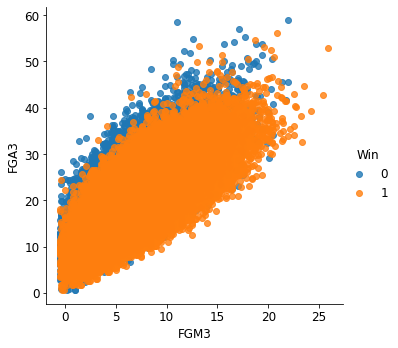

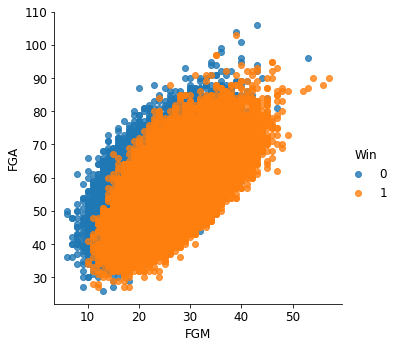

In [12]:
# Plots for FGM vs. FGA, both 2-pointers and 3-pointers
sns.lmplot('FGM3', 'FGA3', data=total, hue='Win', fit_reg=False, x_jitter = .5, y_jitter = .5)
sns.lmplot('FGM', 'FGA', data=total, hue='Win', fit_reg=False)
plt.show()

The final visualization comes from analyzing free-throws, a crucial part of the end of several close games. Free throws are awarded to teams for fouls committed by the opposing defense, and the strategy in the final minutes of a game is often to foul frequently, limiting the total clock run-off for a team that holds the lead. It can become crucial, therefore, to make free-throws in order to maintain a lead in the closing minutes. Indeed, we see that across all seasons, teams who make more free throws are more likely to win.

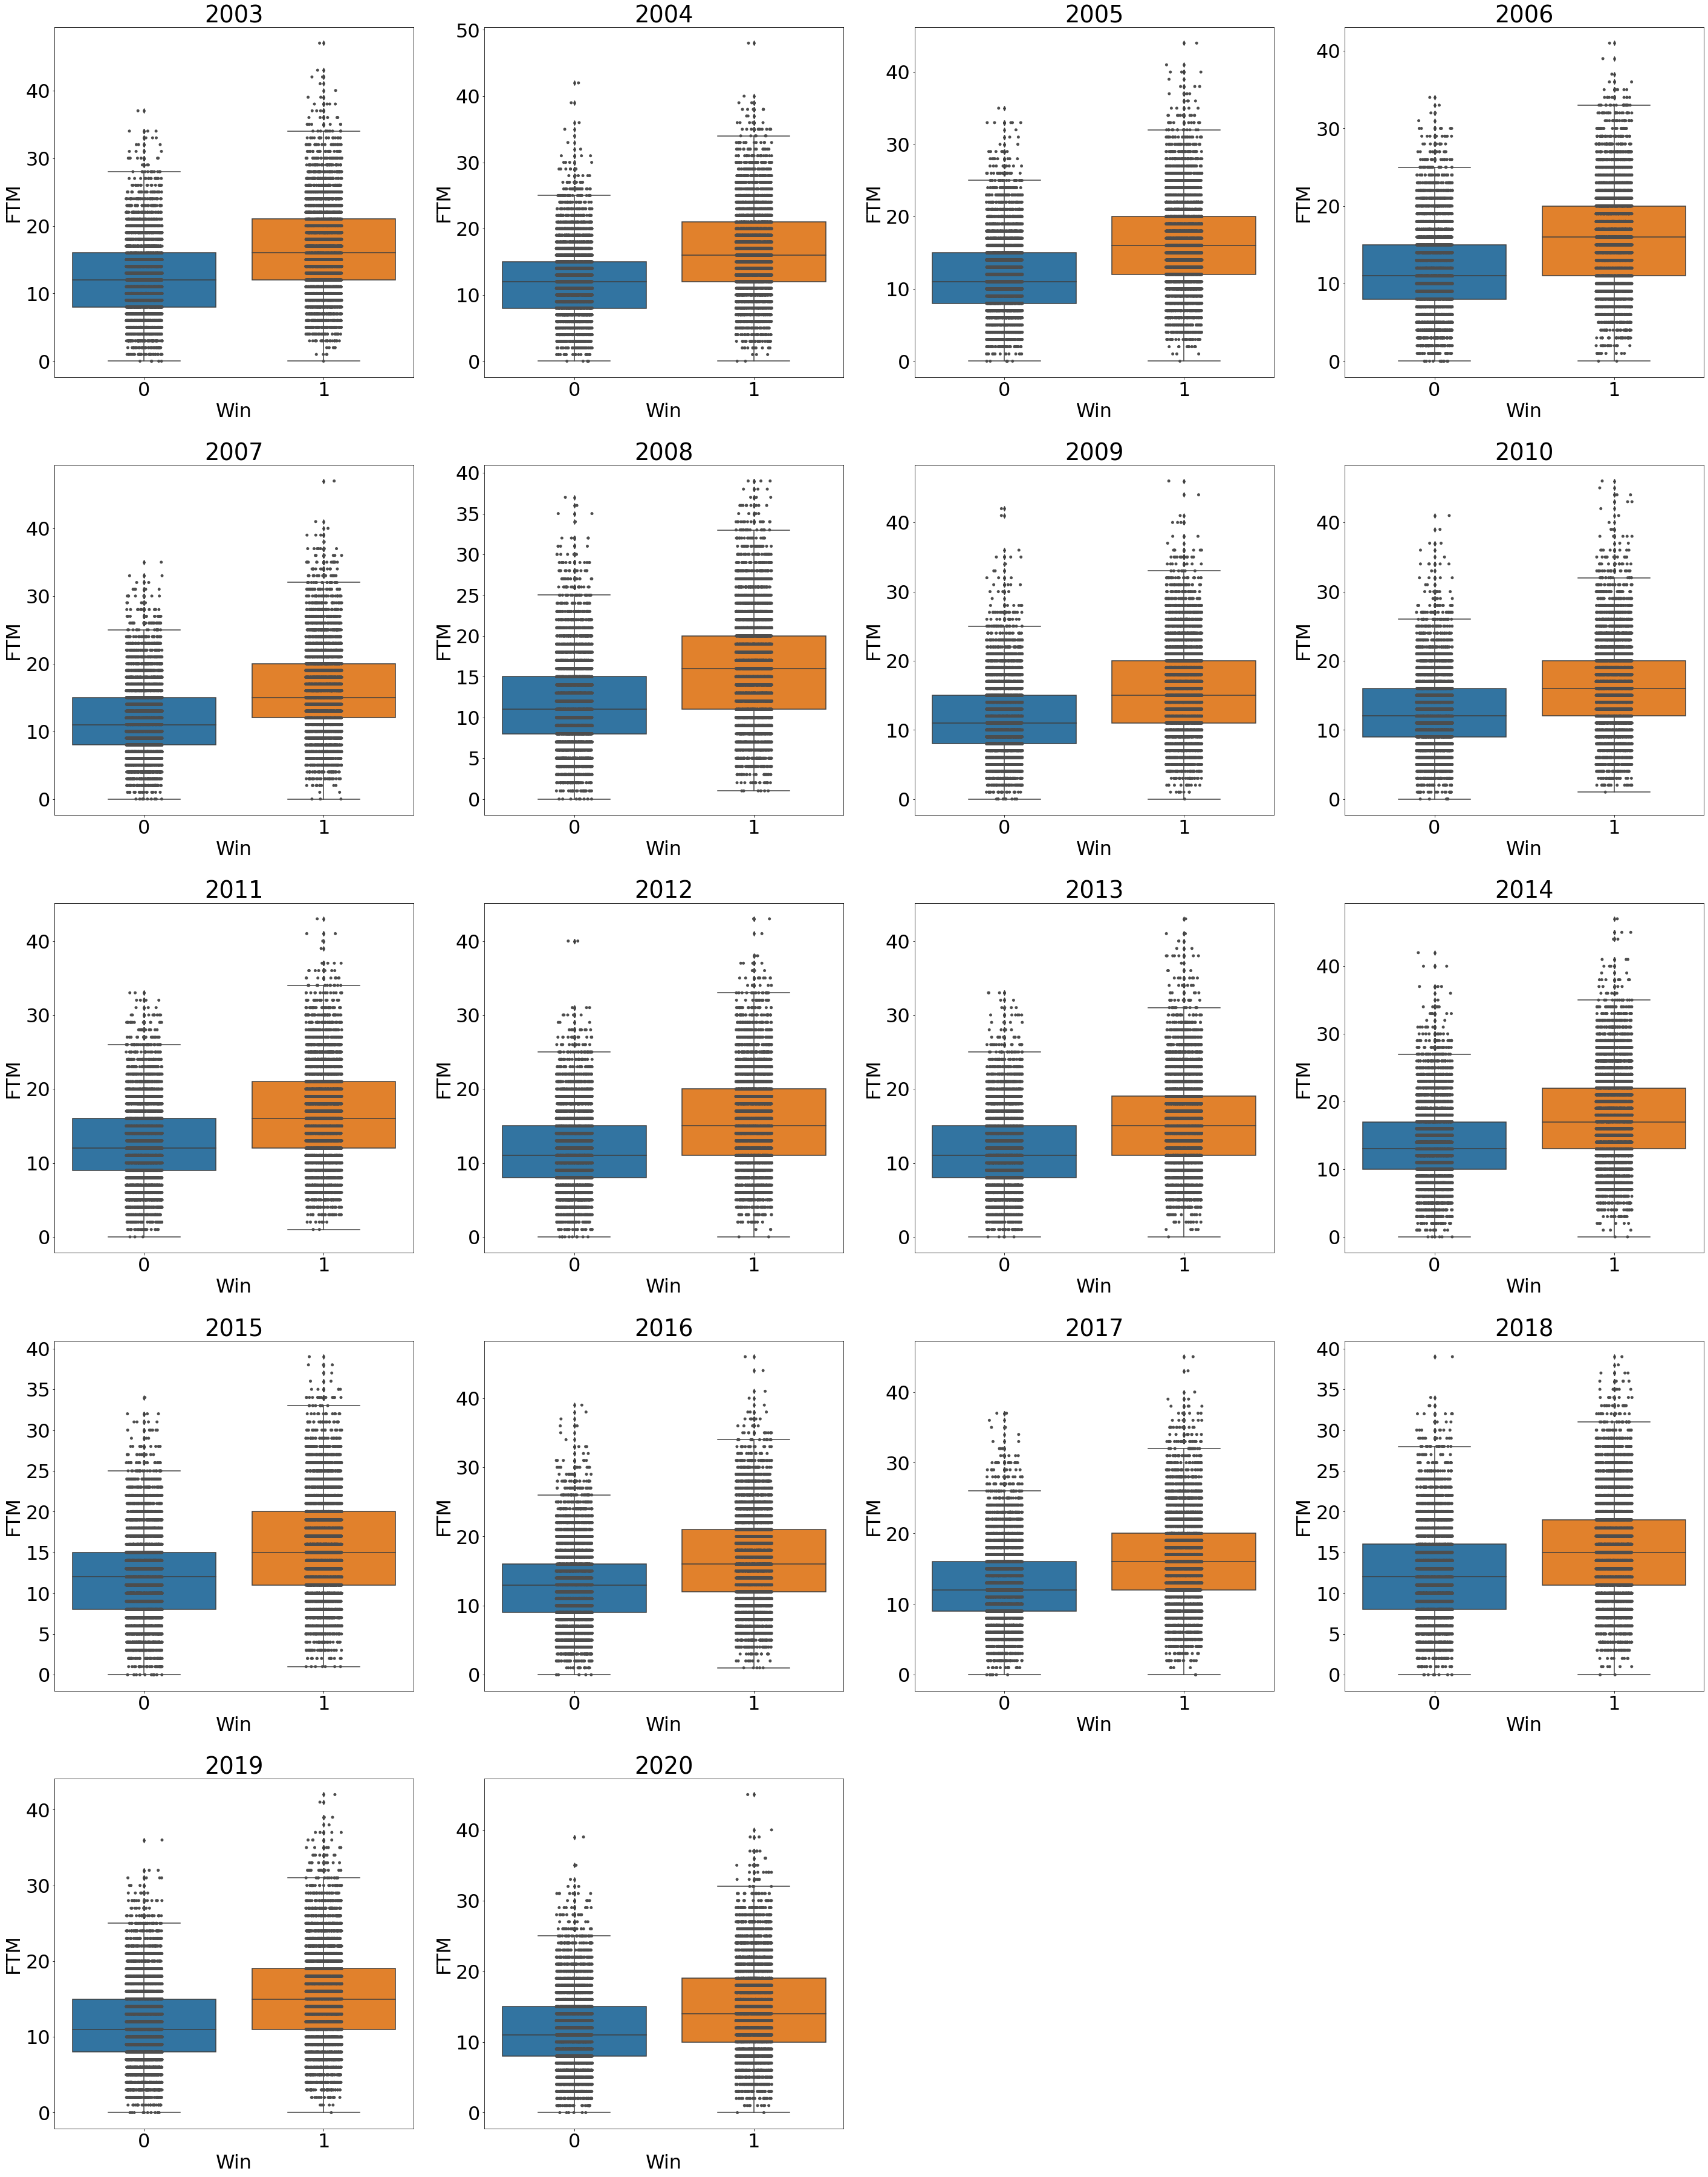

In [13]:
# Loop at Free throws
x = 4
y = int(36/x)
graphframe = pd.DataFrame(data={"Win": total['Win'],"Season": total['Season'], "FTM": total['FTM']})

# Set font size
plt.rcParams["font.size"] = 32
# Set plot size
fig = plt.figure(figsize=(x*10, y*10))
# Loop through each recent season
for i, season in enumerate(range(2003, 1985+x*y)):
    # Generate subplot
    ax = fig.add_subplot(y, x, i+1)
    # Add boxplot
    sns.boxplot(data=graphframe[graphframe['Season']==season], 
                 x='Win', y='FTM', ax=ax)
    # Add strip plot
    sns.stripplot(data=graphframe[graphframe['Season']==season], 
                 x='Win', y='FTM', ax=ax, color='.3')
    # Set title as season
    ax.set_title(season)
# Display
fig.tight_layout()

Having briefly explored some features of the data, we can pivot to establishing a baseline for performance. Our data above represents all of the actual training data we will use for the informed models. To compare the model against a simple heuristic approach that picked for optimal probabilities from seeding pairing, we generated the following table of data, which contains the historic probabilities of teams advancing per round by their given seed. For instance, if a 2-seed team advances to the Sweet 16 (the third round of the tournament, in which only 16 teams remain - hence the name), they have a 71 percent chance of winning their next matchup. Similarly, if a 15-seed team survives the first round (in which they have only a 6 percent change of winning), they are actually more likely to win their second matchup with a 22 percent chance of advancing. This is because consecutive rounds reward the best teams by giving them the lowest probable matchup in the next round. If a 1-seed team beats a 16-seed team in the initial round, they play the winner of the 8-9 matchup, which is most likely to be the lowest remaining seed in the tournament at that stage. 

In [14]:
# Historic Seed Advance Percentage by Round
adv_pct = pd.DataFrame()

# Read in data about win percentage by team
adv_pct['Seed'] = range(1,17)
adv_pct['Round1'] = [.99, .94, .85, .78, .65, .63, .60, .49, .51, .40, .38, .35, .22, .15, .06, .01]
adv_pct['Round2'] = [.86, .67, .61, .59, .53, .48, .32, .20, .10, .40, .44, .43, .19, .09, .22, .00]
adv_pct['Sweet16'] = [.81, .71, .49, .31, .18, .35, .36, .57, .57, .35, .38, .09, .00, .00, .00, .00]
adv_pct['Elite8'] = [.59, .46, .46, .62, .78, .20, .30, .63, .25, .13, .56, .00, .00, .00, .00, .00]
adv_pct['Final4'] = [.61, .43, .65, .23, .43, .67, .33, .60, .00, .00, .00, .00, .00, .00, .00, .00]
adv_pct['Championship'] = [.64, .38, .36, .33, .00, .50, 1, .33, .00, .00, .00, .00, .00, .00, .00, .00]

The below code represents the actual results of the 2022 tournament. Each team receives a three number code - the first digit represents the region (1 = West, 2 = East, 3 = South, 4 = Midwest) that they started in, and the last two digits represent their initial seeded position in this region. Pairs are listed in win-loss order respectively for each round. We will use these results to validate the performance of our sample trials to see how well they did in comparison with the actual outcome of the tournament.

In [15]:
# 2022 Tournament Outcome

# First digit indicates region (1 = West, 2 = East, 3 = South, 4 = Midwest)
# Second digits indicate seed
# Examples 101 = 1 seed in the West = Gonzaga, 201 = 1 seed in the East = Baylor
# Listed pairs are in win loss order (w,l) for each round
R1_winlose = [(101, 116), (109, 108), (112, 105), (104, 113), (111, 106), (103, 114), (107, 110), (102, 115),
              (201, 216), (208, 209), (205, 212), (204, 213), (206, 211), (203, 214), (207, 210), (215, 202),
              (301, 316), (309, 308), (305, 312), (304, 313), (311, 306), (303, 314), (307, 310), (302, 315),
              (401, 416), (409, 408), (412, 405), (404, 413), (411, 406), (403, 414), (410, 407), (402, 415)]

R2_winlose = [(101, 109), (104, 112), (103, 111), (102, 107), (208, 201), (204, 205), (203, 206), (215, 207),
              (301, 309), (305, 304), (311, 303), (302, 307), (401, 409), (404, 412), (411, 403), (410, 402)]

SS_winlose = [(104, 101), (102, 103), (208, 204), (215, 203), (305, 301), (302, 311), (401, 404), (410, 411)]

EE_winlose = [(102, 104), (208, 215), (302, 305), (401, 410)]

FF_winlose = [(208, 102), (401, 302)]

NC_winlose = [(401, 208)]

## Task 2 - Modeling the Probability of a Win

Then we turned to taking the polished data and splitting it into training and testing groups, which would be used to validate each model attempt. Test data received roughly 75% of the original games, sampled randomly across all available seasons in the records. Then, when the data was split into training and testing, the 'Win' column was separated as the target variable. Reminder, this column represents whether the team documented by the line was victorious, given their stats for the season and evening.  
   
Additionally, we also built models to predict win percentage in the regular season based on aggregate statistics and the number of wins in the March Madness tournament based on summary statistics from the regular season.

In [16]:
# Split the data into training and testing
train_df, test_df = train_test_split(total[total.Season != 2022], test_size=0.25, random_state=328)

In [17]:
# Sort the columns
X = train_df[['Score','FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR','Ast', #'Avg Ranking', 'Rank Trajectory - Late'
              'TO', 'Stl', 'Blk', 'PF','OffEff','DefEff']]
# Separate out the target variable
y = train_df[['Win']]

# Drop any rows with missing data from final use
y = y[~X.isna().any(axis=1).values]
X = X[~X.isna().any(axis=1)]

### Linear Regression

Our first model was a simple linear regression. For this model, we ended up choosing a sub-selection of the total set of potential coefficients to be fit. From the game data, we elected to use 'Score','FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR','Ast', 'TO', 'Stl', 'Blk', 'PF','OffEff', and 'DefEff'. From the Massey Index data, we elected to use 'Avg Ranking' and 'Rank Trajectory - Late'. 

In [18]:
# Fit a linear regression
lm = LinearRegression().fit(X,y)

In [19]:
# Examine the fitted coefficients
d = {'Label': ['Score','FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR','Ast', #'Avg Ranking', 'Rank Trajectory - Late',
              'TO', 'Stl', 'Blk', 'PF','OffEff','DefEff'], 'Fitted Coefficient': lm.coef_[0]}
df = pd.DataFrame(data=d)
df

,Label,Fitted Coefficient
0,Score,7.453606e+09
1,FGM,-1.490721e+10
2,FGA,-1.225471e-03
3,FGM3,-7.453606e+09
4,FGA3,-5.475998e-03
5,FTM,-7.453606e+09
6,FTA,6.140709e-03
7,OR,-2.748251e-03
8,DR,6.777287e-03
9,Ast,2.041817e-03


In [20]:
# Model root mean squared error
np.sqrt(mean_squared_error(y,lm.predict(X)))

0.2879591313786074

As we can see, the root mean squared error of the model is 0.28798. This is an improvement over the performance of the baseline 50/50 model, although it could stand to be better improved further by a more rigorous modeling approach. Over the next three models, we considered models which drop or filter out the effects from redundant statistics, based on the findings about the coefficients above. As we can see, there are very large coefficients assigned to offensive and defensive efficiency, while there are small coefficients fitted to every other predictor. Given that these two are aggregate statistics which represent information otherwise captured in the other predictors, there is a high chance that we are facing against multicollinearity in our selected model, which does nothing to remove coefficients from consideration. For this reason, methods like Ridge Regression, AdaBoost, or Random Forest design might make a lot of sense.

### AdaBoost Regressor

The next model that we attempted to build was an AdaBoost regressor. In general, this regressor  is an ensemble method which uses a collection of weak classifiers to increase the aggregate efficiency of a binary classifier. It uses an iterative approach that reweights to amplify mistake from prior rounds, and to learn from the mistaked of weak classifiers to turn them into strong ones. Our hope with this model was to improve on the lackluster performance of the linear regressor. To start, we simply picked a value for n_estimators of 50, to determine whether the model work

In [21]:
# Create AdaBoost model
boost = AdaBoostRegressor(n_estimators=50).fit(X, np.ravel(y))

In [22]:
# Root MSE
np.sqrt(mean_squared_error(y,boost.predict(X)))

0.25147438515763204

The mean squared error has dropped, but not substantially. It seems as though the AdaBoost regressor has made marginal improvements over the prior model, but not substantial. Partly, this could be due to a misparameterization of the selected hyperparameters, so we can proceed with cross validation for the number of trees to explore if there are any possible improvements.

### AdaBoost with K-Fold Validation

In this version, we fit the exact same model, but we use a variety of possible counts for trees and perform 5-fold validation on each to get a more rigorous test of the AdaBoost algorithm.  
  
Surprisingly, the mean validation RMSE actually gets worse as we add more estimators to the model, indicating that we may be overfitting to the training data.

In [23]:
# Set up parameter space
trees = [5,50,100,250,500]
test_mean_rmse = []
test_rmse = []

# Get folds
cv = KFold(n_splits=5, shuffle=True, random_state=5322)

# Loop through parameter space and fit model to each value
for t in trees:
    rg = AdaBoostRegressor(n_estimators=t).fit(X, np.ravel(y))
    scores = -1 * cross_val_score(
      rg, X, np.ravel(y), 
      cv = cv, 
      scoring="neg_root_mean_squared_error"
    )
    test_mean_rmse.append(np.mean(scores))
    test_rmse.append(scores)
    
# Combine results into table
boost_res = pd.DataFrame(
    data = np.c_[trees, test_mean_rmse, test_rmse],
    columns = ["trees", "mean_rmse"] + ["fold" + str(i) for i in range(1,6) ]
)
boost_res

,trees,mean_rmse,fold1,fold2,fold3,fold4,fold5
0,5.0,0.200656,0.197667,0.196889,0.198794,0.204705,0.205226
1,50.0,0.275150,0.267208,0.282511,0.293382,0.271335,0.261312
2,100.0,0.258523,0.267724,0.269701,0.277119,0.223541,0.254529
3,250.0,0.274715,0.253009,0.272124,0.278429,0.295419,0.274592
4,500.0,0.286525,0.290334,0.288259,0.277978,0.277110,0.298946


### Ridge Regression with K-Fold Validation

The next model attempted is the ridge regression. For this model, we created a NumPy logspace of potential values for alpha, the parameter that determines the restriction feature which limits or shrinks the size of fitted coefficients. The larger the alpha term, the more substantial the penalty attached to large coefifficients in the L2-Norm, and the smaller the resulting coefficients will be. To evaluate each rigorously, we performed 5-fold cross validation, which takes the training data, splits it into five equally partioned sub-selections, then uses four to train while evaluating on the fifth repeatedly. The mean RMSE provides the average of these testing errors on the held out data for each fold. 

Across all levels of alpha, we see that the mean validation RMSE does not improve much beyond the performance of the basic linear regression, a sign that we might need to implement more sophisticated techniques still to improve model performance.

In [24]:
# Set up parameter space
alpha = np.logspace(-2,1, 10)
test_mean_rmse = []
test_rmse = []

# Calculate folds
cv = KFold(n_splits=5, shuffle=True, random_state=5322)

# For each parameter value, fit model
for a in alpha:
    rg = Ridge(alpha=a).fit(X, y)
    scores = -1 * cross_val_score(
      rg, X, y, 
      cv = cv, 
      scoring="neg_root_mean_squared_error"
    )
    test_mean_rmse.append(np.mean(scores))
    test_rmse.append(scores)
    
# Combine results into a table
ridge_res = pd.DataFrame(
    data = np.c_[alpha, test_mean_rmse, test_rmse],
    columns = ["alpha", "mean_rmse"] + ["fold" + str(i) for i in range(1,6) ]
)
ridge_res

,alpha,mean_rmse,fold1,fold2,fold3,fold4,fold5
0,0.010000,0.288006,0.287633,0.288082,0.288438,0.288182,0.287694
1,0.021544,0.288006,0.287634,0.288082,0.288438,0.288182,0.287694
2,0.046416,0.288006,0.287634,0.288082,0.288438,0.288182,0.287694
3,0.100000,0.288006,0.287634,0.288083,0.288437,0.288181,0.287694
4,0.215443,0.288006,0.287635,0.288083,0.288436,0.288181,0.287695
5,0.464159,0.288006,0.287637,0.288085,0.288434,0.288180,0.287696
6,1.000000,0.288008,0.287641,0.288088,0.288430,0.288179,0.287700
7,2.154435,0.288013,0.287653,0.288099,0.288424,0.288180,0.287710
8,4.641589,0.288034,0.287686,0.288129,0.288426,0.288191,0.287739
9,10.000000,0.288105,0.287772,0.288217,0.288465,0.288245,0.287824


### Random Forest with Cross Validation

The last technique we considered using is a random forest, which is another example of an ensemble method that assembles the estimates from a collection of randomly iterated and pruned trees to form an aggregate final output. It has been shown to have great success on similar classification problems to ours concerning March Madness, so we ran 5-fold validation across a variety of counts of trees, to see whether we could get an improvement in the mean RMSE.
  
As we can see, additional trees do not improve the mean validation RMSE past 50 or 100, so we will use 75 trees for the future models.

In [25]:
# Set up parameter space
trees = [5,50,100,250,500]
test_mean_rmse = []
test_rmse = []

# Calculate folds
cv = KFold(n_splits=5, shuffle=True, random_state=5322)

# For each parameter value, fit a model
for t in trees:
    rg = RandomForestRegressor(n_estimators=t).fit(X, np.ravel(y))
    scores = -1 * cross_val_score(
      rg, X, np.ravel(y), 
      cv = cv, 
      scoring="neg_root_mean_squared_error"
    )
    test_mean_rmse.append(np.mean(scores))
    test_rmse.append(scores)
    
# Show table of results
random_res = pd.DataFrame(
    data = np.c_[trees, test_mean_rmse, test_rmse],
    columns = ["trees", "mean_rmse"] + ["fold" + str(i) for i in range(1,6) ]
)
random_res

,trees,mean_rmse,fold1,fold2,fold3,fold4,fold5
0,5.0,0.018138,0.017732,0.022892,0.015972,0.015490,0.018605
1,50.0,0.014763,0.014425,0.017942,0.014793,0.012232,0.014422
2,100.0,0.013770,0.012663,0.016977,0.013892,0.012088,0.013229
3,250.0,0.013711,0.012921,0.016624,0.013865,0.011840,0.013303
4,500.0,0.013509,0.012636,0.016423,0.013777,0.011515,0.013194


Out of all models we've considered, Random Forest was substantially better, receiving Mean RMSE scores that are 4 percent of the metrics other models achieved. As such, we elected to use this in our subsequent models to predict season win percentage and number of tournament wins.

### Random Forest with Seasonal Averages

Our model below was built on the Team/Season averages for all the metrics we selected in the earlier stages of our exploration, dropping data from the most recent season, as well as the day and location of each game. We took mean values across all regular season games and used these to predict win percentage for each team.

In [26]:
# Drop 2022 season, Day Number, and Location data
summary_df = total[total.Season != 2022].drop(["DayNum","Loc"],axis=1)

# Group by ID and season, then calculate mean value
summary_df = summary_df.groupby(["TeamID","Season"]).mean()

# Reset the index
summary_df = summary_df.reset_index()

In [27]:
# Assemble the values into useable data frames to be passed into the final model
X_sum = summary_df[['Score','FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR','Ast', 'Avg Ranking', 'Rank Trajectory - Late',
              'TO', 'Stl', 'Blk', 'PF','OffEff','DefEff']]
y_sum = summary_df[['Win']]
y_sum = y_sum[~X_sum.isna().any(axis=1).values]
X_sum = X_sum[~X_sum.isna().any(axis=1)]

In [28]:
# Build the random forest with n = 75 estimators
summary_rf = RandomForestRegressor(n_estimators=75).fit(X_sum, np.ravel(y_sum))

In [29]:
# Examine the importance of the predictors
importance = pd.concat([pd.Series(X_sum.columns),pd.Series(summary_rf.feature_importances_)],axis=1)
importance.columns = ["Variable","Importance"]
importance.sort_values(by = 'Importance')

,Variable,Importance
3,FGM3,0.003567
4,FGA3,0.003718
1,FGM,0.003994
2,FGA,0.004020
0,Score,0.004642
9,Ast,0.004829
7,OR,0.004829
8,DR,0.004862
14,Blk,0.005055
13,Stl,0.005157


Here we see that the two aggregate performance metrics, offensive efficiency and defensive efficiency, are the most significant predictors for a team's success. This makes sense, because they are a metric that captures a team's individual performance absent several of the confounding variables that can muddle the other signals. Pace of play has a large impact on the volume of all other statistics, including points, rebounds, and steals. If two teams elect to use most of the time allocated to them by the shot clock on each consecutive possesion, there will be a lower score for everyone participating, given that the number of possessions drops substantially. Efficiency does not get impacted by these unrecorded variables, and rather speaks to how well a team does for every possession they do obtain. Efficient teams, in short, are far more likely to beat their opponent, regardless of play style.

### Small Forest Regressor

Driven by this finding that Offensive and Defensive Efficiency are primarily responsible for the findings of the model, we constructed a smaller forest model on just average ranking and these two predictors, to see how well it could do.
  
The performance was approximately the same as the last model and more parsimonious, but we elected to keep all variables for our tournament model in case other variables were better predictors of tournament success.

In [30]:
# Limited feature datasets
X_small = summary_df[['Avg Ranking','OffEff','DefEff']]
y_small = summary_df[['Win']]

In [31]:
# Fit model
small_rf = RandomForestRegressor(n_estimators=75).fit(X_small, np.ravel(y_small))

### Isolating tournament performance

For our last model, instead of predicting the probability of a win or win percentage, we decided to predict the number of tournament wins for each team based on their summary statistics from the regular season. Then we can use this model to predict the number of wins in the 2022 tournament based on aggregate statistics from the 2022 regular season.

In [32]:
# Merge tournament data with existing summary data
tourn_data = pd.merge(summary_df,tourn_sum,left_on='TeamID',right_on = 'TeamID')

In [33]:
# Split data for modeling
X_tourn = tourn_data[['Score','FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR','Ast', 'Avg Ranking', 'Rank Trajectory - Late',
              'TO', 'Stl', 'Blk', 'PF','OffEff','DefEff','Win']]
y_tourn = tourn_data[['TournWins']]

In [34]:
# Fit the tournament random forest
tourn_rf = RandomForestRegressor(n_estimators=75).fit(X_tourn, np.ravel(y_tourn))

In [35]:
# Examine importance metrics
tourn_importance = pd.concat([pd.Series(X_tourn.columns),pd.Series(tourn_rf.feature_importances_)],axis=1)
tourn_importance.columns = ["Variable","Importance"]
tourn_importance

,Variable,Importance
0,Score,0.021446
1,FGM,0.023017
2,FGA,0.026389
3,FGM3,0.023899
4,FGA3,0.026379
5,FTM,0.025264
6,FTA,0.023468
7,OR,0.031855
8,DR,0.033947
9,Ast,0.030825


## Task 3 - Tournament 2022 Selection

We use the random forest trained to predict tournament wins to make consecutive guesses for each game in the tournament, through the implementation of a standardized function that takes predicted probabilities for each game outcome, tests them against the model, and determines which team is given a higher probability of winning. Then, once the sequence of outcomes is determined, we will return a formatted version of the outcome bracket, which we can then compare to the actual results of the tournament this year. While no model was able to predict some of the more radical upsets from this year's competition, it is interesting to see how frequently a predicted model would have been able to call some of the observed upsets.

First, we read in the submission stage 2, which presents a set of all the initial matchups for this year's tournament. We separate out each ID into the year, Team 1, and Team 2 categories, then proceed to merge each with the full set of averaged predictors from the most recent year of data from our regular season information. Then, taking the fully formatted data, we use the random forest to make predictions for the win probabilities of each team. We take the proportional ratio of (Team A Win Prob %) / (Team A Win Prob % + Team B Win Prob %) as the likelihood of the first team winning the game, then reattach these predictions as probabilities to the unique game identifiers. As a set, these identifiers provide every possible match-up that could be encountered in the tournament. 

In [36]:
# Read in sample submission
sub_stage_one = pd.read_csv('data/MSampleSubmissionStage2.csv')
# Copy over the data
tst_data = sub_stage_one.copy()
# Split the identifier by ID: https://www.kaggle.com/code/masaishi/get-tournament-result-from-prediction
def separate_id(df):
    df['Season']  = df['ID'].apply(lambda x: int(x.split('_')[0]))
    df['TeamIdA'] = df['ID'].apply(lambda x: int(x.split('_')[1]))
    df['TeamIdB'] = df['ID'].apply(lambda x: int(x.split('_')[2]))
    return df

# Execute function on test data
tst_data = separate_id(tst_data)
# Rename columns for predictions
tst_data.rename(columns = {'Pred':'PredA'}, inplace = True)
tst_data['PredB'] = .5

# Select first for only Team A
team_a = tst_data[['TeamIdA']]

# Merge in features from data
team_a = team_a.merge(total[total.Season == 2022].groupby(['TeamID'], as_index = False).mean(), left_on='TeamIdA', right_on='TeamID')
# General predictions from the model

tst_data['PredA'] = tourn_rf.predict(team_a[['Score','FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR','Ast', 'Avg Ranking', 'Rank Trajectory - Late',
              'TO', 'Stl', 'Blk', 'PF','OffEff','DefEff','Win']])

# Do the same for Team B
team_b = tst_data[['TeamIdB']]
team_b = team_b.merge(total[total.Season == 2022].groupby(['TeamID'], as_index = False).mean(), left_on='TeamIdB', right_on='TeamID')
tst_data['PredB'] = tourn_rf.predict(team_b[['Score','FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR','Ast', 'Avg Ranking', 'Rank Trajectory - Late',
              'TO', 'Stl', 'Blk', 'PF','OffEff','DefEff','Win']])

In [37]:
# Make a predictor ratio for who will win the game, and by how much in probability
d = {'ID': tst_data['ID'], 'Pred': tst_data['PredA'] / (tst_data['PredB'] + tst_data['PredA'])}
df = pd.DataFrame(data=d)

# Save output so that we don't need to train again to make predictions
df.to_csv('data/Predictions/RandomForestOutput.csv', index = False)
print(df)

                  ID      Pred
0     2022_1103_1104  0.144596
1     2022_1103_1112  0.105557
2     2022_1103_1116  0.105557
3     2022_1103_1120  0.172196
4     2022_1103_1124  0.172196
...              ...       ...
2273  2022_1458_1461  0.784861
2274  2022_1458_1463  0.784861
2275  2022_1460_1461  0.364916
2276  2022_1460_1463  0.364916
2277  2022_1461_1463  0.625355

[2278 rows x 2 columns]


The following code for visualizing our estimated bracket, built by our model, was inspired by the following: https://www.kaggle.com/code/masaishi/get-tournament-result-from-prediction. It takes all of the possible match-ups that are listed in the output file above, selects for the winning team, then feeds the remaining teams forward into the next round of the tournament, at which point the process iteratively continues for every generated match-up until a winner is picked. The results are then visualized into the console in a rudimentary bracket. However, for our specific project, several adaptations needed to be made to this original code from online. Namely, we wanted to ensure that consecutive pairs represented the real match-ups, not just random pairings of teams, and we also wanted to visualize each region as an original set of branches, from which only one winner emerged to participate in the Final Four. To do so, we gave an inherent ordering to the teams in the bracket below, which ensured that they were always organized correctly when output to the console:

In [38]:
# Load the path to access data files
DATA_PATH = 'data/'

# Grab information regarding the seeds of each team
seeds = pd.read_csv(DATA_PATH + 'MNCAATourneySeeds.csv')
seeds = seeds[seeds.Season==2022]

# Load information about the slots of various teams
slots = pd.read_csv(DATA_PATH + 'MNCAATourneySeedRoundSlots.csv')

# Merge seeds and slots, then create game pairs
slot_seeds = pd.merge(seeds,slots,on='Seed')
game_pairs = pd.merge(slot_seeds[['TeamID','GameSlot','GameRound']],
slot_seeds[['TeamID','GameSlot','GameRound']], on = ['GameSlot'])

# Save game pairs for scaffolding
game_pairs['Round'] = game_pairs['GameRound_x']
game_pairs = game_pairs[game_pairs['TeamID_x'] > game_pairs['TeamID_y']].copy()
game_pairs['ID'] = '2022_' + game_pairs['TeamID_y'].astype(str) + '_' + game_pairs['TeamID_x'].astype(str)

# Index scaffolding 
fist_four_index = game_pairs[game_pairs['GameSlot'].str[0] != 'R'].index

# By handle as R1?5 to set middle.
first_four_game_id = ['2022_1231_1461', '2022_1323_1353', '2022_1394_1411', '2022_1136_1460']
game_pairs.loc[6326, 'GameSlot'] = 'R1W4'
game_pairs.loc[6874, 'GameSlot'] = 'R1X5'
game_pairs.loc[8578, 'GameSlot'] = 'R1Y0'
game_pairs.loc[9126, 'GameSlot'] = 'R1Z0'

# Sort the values
game_pairs = game_pairs.sort_values(by='GameSlot')

# Generate unique ids for each game
game_ids = []
for x, y in zip(game_pairs['TeamID_x'], game_pairs['TeamID_y']):
    if not y in game_ids:
        game_ids.append(y)
    if not x in game_ids:
        game_ids.append(x)

# Initialize data frames
survived_pairs = pd.DataFrame([])
survived_ids = []

# Create function to drop losing team from consideration
def drop_lose_team(pairs):
    global survived_pairs, survived_ids
    survived_pairs = survived_pairs.drop(pairs.index)
    for index, row in pairs.iterrows():
        if row['Pred'] > 0.5:
            drop_team = row['TeamID_x']
        else:
            drop_team = row['TeamID_y']
        survived_pairs = survived_pairs[survived_pairs['TeamID_x']!=drop_team]
        survived_pairs = survived_pairs[survived_pairs['TeamID_y']!=drop_team]
        survived_ids.remove(drop_team)

# Create the custom order by which to sort teams
custom_order = {c:i for i,c in enumerate(['Baylor','Norfolk St.', 'North Carolina','Marquette', "St Mary's CA", "Indiana", "UCLA", "Akron", "Texas", "Virginia Tech",
                                            "Purdue", "Yale", "Murray St", "San Francisco", "Kentucky", "St Peter's", "Gonzaga", "Georgia St", "Boise St", "Memphis", 
                                            "Connecticut", "New Mexico St", "Arkansas", "Vermont", "Alabama", "Notre Dame","Rutgers", "Texas Tech", "Montana St", "Michigan St", 
                                            "Davidson", "Duke", "Cal St Fullerton", "Jacksonville St", "Auburn","Miami FL", "USC","Colgate", "Wisconsin","Iowa St","LSU", "S Dakota St", 
                                            "Providence",  "Richmond","Iowa","Creighton",  "San Diego St", "W Texas A&M", "Kansas",
                                            "Delaware","Villanova", "Loyola-Chicago",  "Ohio St","Longwood","Tennessee","Michigan", "Colorado St", 
                                            "Chattanooga","Illinois","UAB", "Houston",  "TCU","Seton Hall","Wright St", "Arizona"])}        
        
# Create a function to sort on a custom order for character vector
def customSort(l):
    l.sort(key=lambda c:custom_order.get(c, len(custom_order)))
    
# Create a function to execute this sort above
def customSorted(l):
    return sorted(l, key=lambda c:custom_order.get(c, len(custom_order)))

# Create function to visualize outcomes 
def show_tournament(SHOW_DEPTH, submission):
    global game_pairs, game_ids, survived_pairs, survived_ids, fist_four_index
    
    # Connect game_pairs to submission.
    survived_pairs = game_pairs.merge(submission[['ID', 'Pred']], on='ID', how='left')
    survived_pairs = survived_pairs.sort_values(by='GameSlot')
    survived_ids = game_ids.copy()
    
    # First Four
    first_four = pd.concat([survived_pairs[survived_pairs['GameSlot'].str[1] == '1'][survived_pairs['ID'] == game_id] for game_id in first_four_game_id])
    pairs = first_four.drop_duplicates(subset='ID', keep='first')
    drop_lose_team(pairs)

    result = []
    # Full tournament
    for i in range(1,6):
        pairs = survived_pairs[survived_pairs['GameSlot'].str[1] == str(i)]
        drop_lose_team(pairs)
        if i > 6-SHOW_DEPTH:
            result.append(survived_ids.copy())
    # Append correct winner to output
    last_pair = survived_pairs.iloc[0]
    if last_pair['Pred'] > 0.5:
        result.append([last_pair['TeamID_y']])
    else:
        result.append([last_pair['TeamID_x']])
    
    # Access all team names from codes
    team = pd.read_csv('data/MTeams.csv')
    
    # Create a dictionary of team codes and names
    trans_dict = dict(zip(team.TeamID, team.TeamName))
    
    # For each team, reorganize by ordering above
    for depth in range(len(result)):
        result[depth] = [trans_dict[i] for i in result[depth]]
        result[depth] = customSorted(result[depth])
        result[depth] = [list(trans_dict.keys())[list(trans_dict.values()).index(i)] for i in result[depth]]
    
    
    # Add show_text list to show
    show_text = [''] * (2**len(result)-1)
    depth = 0
    for depth in range(len(result)):
        for i in range(len(show_text)):
            position = i - (2**depth) + 1
            if position % 2**(depth+1) == 0:
                team_id = result[depth][int(i / (2**(depth+1)))]
                show_text[i] += team[team['TeamID'] == team_id]['TeamName'].iloc[0][:9].ljust(10)
                # Additionally, add brackets for visualization
                if position % 2**(depth+2) == 0:
                    show_text[i] += '━┓  '
                else:
                    show_text[i] += '━┛  '
            else:
                if position % (2**(depth+2)) == 2**(depth):
                    show_text[i] += ' '.ljust(11) + '┃━ '
                elif (position % (2**(depth+2))) < 2**(depth+1):
                    show_text[i] += ' '.ljust(11) + '┃  '
                else:
                    show_text[i] += ' '.ljust(14)

    # Showing tournament
    for text in show_text:
        print(text[:-4])

In our model, we consider a "success" the event of estimating the winner of a game, irrespective of the loser. In this way, a false guess in the first round does not propogate through consecutive rounds. To illustrate this, let us imagine that we picked Auburn over Jacksonville St. and USC over Miami in the first round. Auburn did indeed win, but Miami took the victory over USC, so we would have 1/2 guesses correct. In the second round, let's say we also picked Auburn to win, albeit over a USC team that did not advance. We would still have 2/3 guesses correct, given we picked the right team to advance, even if the match-up was not correct. This methodology is consistent with ESPN's Bracketology approach to scoring competitive brackets.

The bracket combines all of the match-ups and advances a team whenever they win a specific match-up, determine by the win probability ratio outlined in the discussion above. Then, they face the winner of the branched game associated with their outcome, until only one team remains.

In [39]:
# Please load your submission file here
SUB_PATH = 'data/Predictions/RandomForestOutput.csv'
submission = pd.read_csv(SUB_PATH)

# 64 Teams Tournament
show_tournament(6,submission)

Baylor    ━┓                                                                    
           ┃━ Baylor    ━┓                                                      
North Car ━┛             ┃                                                      
                         ┃━ Baylor    ━┓                                        
Indiana   ━┓             ┃             ┃                                        
           ┃━ Indiana   ━┛             ┃                                        
UCLA      ━┛                           ┃                                        
                                       ┃━ Baylor    ━┓                          
Texas     ━┓                           ┃             ┃                          
           ┃━ Purdue    ━┓             ┃             ┃                          
Purdue    ━┛             ┃             ┃             ┃                          
                         ┃━ Purdue    ━┛             ┃                          
San Franc ━┓             ┃  

To give a sense for performance by round, we have constructed the table below giving percentage of correct guesses at every level:

In [40]:
rf_acc = pd.DataFrame()

rf_acc['Round'] = ['Round1', 'Round2', 'Sweet16', 'Elite8', 'Final4', 'Championship', 'Total']
rf_acc['Tournament Random Forest'] = ["{:.2%}".format(19/32), "{:.2%}".format(7/16),  "{:.2%}".format(1/8),
                                     "{:.2%}".format(0/4), "{:.2%}".format(0/2),"{:.2%}".format(0/1), "{:.2%}".format(28/(32+16+8+4+2+1))]
rf_acc

,Round,Tournament Random Forest
0,Round1,59.38%
1,Round2,43.75%
2,Sweet16,12.50%
3,Elite8,0.00%
4,Final4,0.00%
5,Championship,0.00%
6,Total,44.44%


Clearly, our best performing model struggled to produce estimates that reflected the actual outcome from this year's tournament. While a rate of 43.75 percent in the second round is well above average, only one of the teams that the model guessed would advance to the Elite Eight (Duke) actually made it that far in the tournament, and none of the teams in the Final Four were predicted accurately. But how does this model's prediction hold up against reasonable competition? To answer that question, we began with a multi-stage simulation approach, to compare out model's performance against a baseline for predictive ability. We attacked three seperate simulation methods:

- The first simulation uses a random flip of a coin to determine the winner of each match-up, then compares the overall performance of predicting game outcomes for each consecutive round of the tournament. As can be seen from the results, it becomes increasingly difficult to generate correct guesses as the rounds continue. When a random team is drawn, in the first round, we would expect half of the guesses to be correct. Then, for the second round, assuming that half of the teams that advanced were correct, we would expect only one half of those teams to be guessed correctly as the winners. This number divides in half roughly for each consecutive round. 
- Next, we explored a simulation in which we drew from a binomial distribution with p equal to the historic advance percentage for the high seed. 
- The third simulation did the same only with p equal to the historic advance percentage for a low seed. For first round matchups, these methods are identical because a 16 seed always plays a 1 seed and so on for all successive match-ups, but as the rounds continue the methods begin to differ. 

As expected, both of these methods offered better prediction than the coin flip scenario, with overall succes rates of about 50%. Clearly, using information regarding seed makes a difference. The overall improvement in estimation totals roughly 16 percent for both HighSeed and LowSeed approaches. The final simulation approach we took was to replicate the findings from our model several times, using the win probability ratio as the percentage chance of victory for the better team. In this way, we attempted to resolve some of the random behavior that a single instance of the tournament outcomes might produce. In our specific example, this can be well captured by the severe drop-off between the Sweet Sixtten and Final Four, where we had several close games go the wrong way in our predictions.

A few notes on the code: wherever possible, we tried to parallelize calculations, write functions to replace repetitive code, and otherwise improve the formatting and efficiency. Given that each model is hierarchical in structure, consecutive rounds of the tournament are predicated on the results being finalized from the prior round. As such, each simulation must proceed only once the last round simulation has concluded, and information about remaining teams feeds forward to set up the next round's predictions. Additionally, while the simulations are similar in general structure, they each use different logic and comparison tests to advance teams into the next round, which prevents us from further consolidating the models. 

The first model below represents our "coin flip" model, which picks randomly and equally between the two teams in each match-up:

In [41]:
# 50/50 Simulation
np.random.seed(5)

# Read in first round statistics
R1_std = [(101, 116), (108, 109), (105, 112), (104, 113), (106, 111), (103, 114), (107, 110), (102, 115),
          (201, 216), (208, 209), (205, 212), (204, 213), (206, 211), (203, 214), (207, 210), (202, 215),
          (301, 316), (308, 309), (305, 312), (304, 313), (306, 311), (303, 314), (307, 310), (302, 315),
          (401, 416), (408, 409), (405, 412), (404, 413), (406, 411), (403, 414), (407, 410), (402, 415)]

# Initialize vectors to store outcomes
R1_Sum1, R2_Sum1, SS_Sum1, EE_Sum1, FF_Sum1, NC_Sum1 =  [], [], [], [], [], []

# Create a function to construct tournament framework
def Create_Framework():
    return [[0,0] for i in range(32)], [[0,0] for i in range(16)], [[0,0] for i in range(8)], \
            [[0,0] for i in range(4)], [[0,0] for i in range(2)],  [[0,0]]

# Create a function to simulate the first round in a standard tournament
def SimRoundOne(outcome, empty_R1, R1_std, R1, R1_winlose):
    for j in range(32):
        empty_R1[j][0] = R1_std[j][1-outcome[j]]
        empty_R1[j][1] = R1_std[j][outcome[j]]
        if empty_R1[j][0] == R1_winlose[j][0]:
            R1 = R1 + 1 
    return(empty_R1, R1)

# Create a function to simulate second round of standard tournament
def SimRoundTwo(outcome, empty_R2, R2_std, R2, R2_winlose):
    index = 0
    for k in range(32, 48, 1):
        if int(str(empty_R1[index][0])[-2:]) > int(str(empty_R1[index+1][0])[-2:]):
            empty_R2[k-32][0] = empty_R1[index+outcome[k]][0]
            empty_R2[k-32][1] = empty_R1[index+1-outcome[k]][0]
        if int(str(empty_R1[index][0])[-2:]) < int(str(empty_R1[index+1][0])[-2:]):
            empty_R2[k-32][0] = empty_R1[index+1-outcome[k]][0]
            empty_R2[k-32][1] = empty_R1[index+outcome[k]][0]
        if empty_R2[k-32][0] == R2_winlose[k-32][0]:
            R2 = R2 + 1
        index = index + 2
    return(empty_R2, R2)

# Generate 100,000 sample runs of the tournament to get average win percentages 
for i in range(100000):
    
    # Create match-up bracket shape
    outcome = np.random.binomial(n = 1, p = .50, size = 63)
    empty_R1, empty_R2, empty_SS,empty_EE, empty_FF,empty_NC = Create_Framework()
    
    # Initialize values
    R1, R2 , SS, EE, FF, NC, = 0,0,0,0,0,0 
    
    # Simulate first round outcomes and store winners 
    empty_R1, R1 = SimRoundOne(outcome, empty_R1, R1_std, R1, R1_winlose)       
    R1_Sum1.append(R1)
    
    # Simulate Round of 32 outcomes and store results, based on last round winners
    empty_R2, R2 = SimRoundTwo(outcome, empty_R2, R1_std, R2, R2_winlose)
    R2_Sum1.append(R2)
    
    # Simulate Sweet 16 outcomes, then store results, based on last round winners 
    index = 0
    for l in range(48, 56, 1):
        if int(str(empty_R2[index][0])[-2:]) > int(str(empty_R2[index+1][0])[-2:]):
            empty_SS[l-48][0] = empty_R2[index+outcome[l]][0]
            empty_SS[l-48][1] = empty_R2[index+1-outcome[l]][0]
        if int(str(empty_R2[index][0])[-2:]) < int(str(empty_R2[index+1][0])[-2:]):
            empty_SS[l-48][0] = empty_R2[index+1-outcome[l]][0]
            empty_SS[l-48][1] = empty_R2[index+outcome[l]][0]
        if empty_SS[l-48][0] == SS_winlose[l-48][0]:
            SS = SS + 1
        index = index + 2
    SS_Sum1.append(SS)
    
    # Simulate Elite 8 outcomes
    index = 0
    for m in range(56, 60, 1):
        if int(str(empty_SS[index][0])[-2:]) > int(str(empty_SS[index+1][0])[-2:]):
            empty_EE[m-56][0] = empty_SS[index+outcome[m]][0]
            empty_EE[m-56][1] = empty_SS[index+1-outcome[m]][0]
        if int(str(empty_SS[index][0])[-2:]) < int(str(empty_SS[index+1][0])[-2:]):
            empty_EE[m-56][0] = empty_SS[index+1-outcome[m]][0]
            empty_EE[m-56][1] = empty_SS[index+outcome[m]][0]
        if empty_EE[m-56][0] == EE_winlose[m-56][0]:
            EE = EE + 1
        index = index + 2
    EE_Sum1.append(EE)
    
    # Final Four results
    index = 0
    for n in range(60, 62, 1):
        if int(str(empty_EE[index][0])[-2:]) > int(str(empty_EE[index+1][0])[-2:]):
            empty_FF[n-60][0] = empty_EE[index+outcome[n]][0]
            empty_FF[n-60][1] = empty_EE[index+1-outcome[n]][0]
        if int(str(empty_EE[index][0])[-2:]) < int(str(empty_EE[index+1][0])[-2:]):
            empty_FF[n-60][0] = empty_EE[index+1-outcome[n]][0]
            empty_FF[n-60][1] = empty_EE[index+outcome[n]][0]
        if empty_FF[n-60][0] == FF_winlose[n-60][0]:
            FF = FF + 1
        index = index + 2
    FF_Sum1.append(FF)
    index = 0
    
    # And finally pick a winner of the tournament
    if int(str(empty_FF[index][0])[-2:]) > int(str(empty_FF[index+1][0])[-2:]):
        empty_NC[0][0] = empty_FF[index+outcome[-1]][0]
        empty_NC[0][1] = empty_FF[index+1-outcome[-1]][0]
    if int(str(empty_FF[index][0])[-2:]) < int(str(empty_FF[index+1][0])[-2:]):
        empty_NC[0][0] = empty_FF[index+1-outcome[-1]][0]
        empty_NC[0][1] = empty_FF[index+outcome[-1]][0]
    if empty_NC[0][0] == NC_winlose[0][0]:
        NC = NC + 1
    NC_Sum1.append(NC)

The code below represents our second simulation, taking the high seed win percentage as the probability:

In [42]:
# High Seed Historic Percentage
np.random.seed(5)

# Initialize shape and order of seeds
R1_Sum2, R2_Sum2, SS_Sum2, EE_Sum2, FF_Sum2, NC_Sum2 = [], [], [], [], [], []
R1_high_order = [1, 8, 5, 4, 6, 3, 7, 2, 1, 8, 5, 4, 6, 3, 7, 2, 
                1, 8, 5, 4, 6, 3, 7, 2, 1, 8, 5, 4, 6, 3, 7, 2]

for i in range(100000):
    # Create framework
    empty_R1, empty_R2, empty_SS,empty_EE, empty_FF,empty_NC = Create_Framework()
    R1, R2, SS, EE, FF, NC = 0, 0, 0, 0, 0, 0
    
    # Simulate Round of 64
    for j in range(32):
        outcome = np.random.binomial(n = 1, p = adv_pct['Round1'][R1_high_order[j]-1], size = 1)
        empty_R1[j][0] = R1_std[j][1-outcome[0]]
        empty_R1[j][1] = R1_std[j][outcome[0]]
        if empty_R1[j][0] == R1_winlose[j][0]:
            R1 = R1 + 1
    R1_Sum2.append(R1)
    index = 0

    # Simulate Round of 32
    for k in range(32, 48, 1):
        if int(str(empty_R1[index][0])[-2:]) > int(str(empty_R1[index+1][0])[-2:]):
            outcome = np.random.binomial(n = 1, p = adv_pct['Round2'][int(str(empty_R1[index+1][0])[-2:]) - 1], size = 1)
            empty_R2[k-32][0] = empty_R1[index+outcome[0]][0]
            empty_R2[k-32][1] = empty_R1[index+(1-outcome[0])][0]
        if int(str(empty_R1[index][0])[-2:]) < int(str(empty_R1[index+1][0])[-2:]):
            outcome = np.random.binomial(n = 1, p = adv_pct['Round2'][int(str(empty_R1[index][0])[-2:]) - 1], size = 1)
            empty_R2[k-32][0] = empty_R1[index+(1-outcome[0])][0]
            empty_R2[k-32][1] = empty_R1[index+outcome[0]][0]
        if empty_R2[k-32][0] == R2_winlose[k-32][0]:
            R2 = R2 + 1
        index = index + 2
    R2_Sum2.append(R2)
    index = 0

    # Simulate Round of 16
    for l in range(48, 56, 1):
        if int(str(empty_R2[index][0])[-2:]) > int(str(empty_R2[index+1][0])[-2:]):
            outcome = np.random.binomial(n = 1, p = adv_pct['Sweet16'][int(str(empty_R2[index+1][0])[-2:]) - 1], size = 1)
            empty_SS[l-48][0] = empty_R2[index+outcome[0]][0]
            empty_SS[l-48][1] = empty_R2[index+(1-outcome[0])][0]
        if int(str(empty_R2[index][0])[-2:]) < int(str(empty_R2[index+1][0])[-2:]):
            outcome = np.random.binomial(n = 1, p = adv_pct['Sweet16'][int(str(empty_R2[index][0])[-2:]) - 1], size = 1)
            empty_SS[l-48][0] = empty_R2[index+(1-outcome[0])][0]
            empty_SS[l-48][1] = empty_R2[index+outcome[0]][0]
        if empty_SS[l-48][0] == SS_winlose[l-48][0]:
            SS = SS + 1
        index = index + 2
    SS_Sum2.append(SS)
    index = 0

    # Simulate Elite 8
    for m in range(56, 60, 1):
        if int(str(empty_SS[index][0])[-2:]) > int(str(empty_SS[index+1][0])[-2:]):
            outcome = np.random.binomial(n = 1, p = adv_pct['Elite8'][int(str(empty_SS[index+1][0])[-2:]) - 1], size = 1)
            empty_EE[m-56][0] = empty_SS[index+outcome[0]][0]
            empty_EE[m-56][1] = empty_SS[index+(1-outcome[0])][0]
        if int(str(empty_SS[index][0])[-2:]) < int(str(empty_SS[index+1][0])[-2:]):
            outcome = np.random.binomial(n = 1, p = adv_pct['Elite8'][int(str(empty_SS[index][0])[-2:]) - 1], size = 1)
            empty_EE[m-56][0] = empty_SS[index+(1-outcome[0])][0]
            empty_EE[m-56][1] = empty_SS[index+outcome[0]][0]
        if empty_EE[m-56][0] == EE_winlose[m-56][0]:
            EE = EE + 1
        index = index + 2
    EE_Sum2.append(EE)
    index = 0

    # Simulate Final Four
    for n in range(60, 62, 1):
        if int(str(empty_EE[index][0])[-2:]) > int(str(empty_EE[index+1][0])[-2:]):
            outcome = np.random.binomial(n = 1, p = adv_pct['Final4'][int(str(empty_EE[index+1][0])[-2:]) - 1], size = 1)
            empty_FF[n-60][0] = empty_EE[index+outcome[0]][0]
            empty_FF[n-60][1] = empty_EE[index+(1-outcome[0])][0]
        if int(str(empty_EE[index][0])[-2:]) < int(str(empty_EE[index+1][0])[-2:]):
            outcome = np.random.binomial(n = 1, p = adv_pct['Final4'][int(str(empty_EE[index][0])[-2:]) - 1], size = 1)
            empty_FF[n-60][0] = empty_EE[index+1-outcome[0]][0]
            empty_FF[n-60][1] = empty_EE[index+outcome[0]][0]
        if int(str(empty_EE[index][0])[-2:]) == int(str(empty_EE[index+1][0])[-2:]):
            outcome = np.random.binomial(n = 1, p = .5, size = 1)
            empty_FF[n-60][0] = empty_EE[index+outcome[0]][0]
            empty_FF[n-60][1] = empty_EE[index+1-outcome[0]][0]  
        if empty_FF[n-60][0] == FF_winlose[n-60][0]:
            FF = FF + 1
        index = index + 2
    FF_Sum2.append(FF)
    index = 0
    
    # Simulate National Championship
    if int(str(empty_FF[index][0])[-2:]) > int(str(empty_FF[index+1][0])[-2:]):
        outcome = np.random.binomial(n = 1, p = adv_pct['Championship'][int(str(empty_EE[index+1][0])[-2:]) - 1], size = 1)
        empty_NC[0][0] = empty_FF[index+outcome[0]][0]
        empty_NC[0][1] = empty_FF[index+1-outcome[0]][0]
    if int(str(empty_FF[index][0])[-2:]) < int(str(empty_FF[index+1][0])[-2:]):
        outcome = np.random.binomial(n = 1, p = adv_pct['Championship'][int(str(empty_EE[index][0])[-2:]) - 1], size = 1)
        empty_NC[0][0] = empty_FF[index+1-outcome[0]][0]
        empty_NC[0][1] = empty_FF[index+outcome[0]][0]         
    if int(str(empty_FF[index][0])[-2:]) == int(str(empty_FF[index+1][0])[-2:]):
        outcome = np.random.binomial(n = 1, p = .5, size = 1)
        empty_NC[0][0] = empty_FF[index+outcome[0]][0]
        empty_NC[0][1] = empty_FF[index+1-outcome[0]][0] 
    if empty_NC[0][0] == NC_winlose[0][0]:
            NC = NC + 1

    NC_Sum2.append(NC)    


The third simulation is very similar, using the low seed historic percentages instead:

In [43]:
# Low Seed Historic Percentage
np.random.seed(5)

# Set up scaffolding
R1_Sum3, R2_Sum3, SS_Sum3, EE_Sum3, FF_Sum3, NC_Sum3 = [], [], [], [], [], []
R1_low_order = [16, 9, 12, 13, 11, 14, 10, 15, 16, 9, 12, 13, 11, 14, 10, 15, 
                16, 9, 12, 13, 11, 14, 10, 15, 16, 9, 12, 13, 11, 14, 10, 15]

for i in range(100000):
    # Initialize tournament outcomes
    empty_R1, empty_R2, empty_SS,empty_EE, empty_FF,empty_NC = Create_Framework()
    R1, R2, SS, EE, FF, NC = 0, 0, 0, 0, 0, 0
    
    # Simulate Round of 64
    for j in range(32):
        outcome = np.random.binomial(n = 1, p = adv_pct['Round1'][R1_low_order[j]-1], size = 1)
        empty_R1[j][0] = R1_std[j][outcome[0]]
        empty_R1[j][1] = R1_std[j][1-outcome[0]]
        if empty_R1[j][0] == R1_winlose[j][0]:
            R1 = R1 + 1
    R1_Sum3.append(R1)
    index = 0
    
    # Simulate Round of 32
    for k in range(32, 48, 1):
        if int(str(empty_R1[index][0])[-2:]) > int(str(empty_R1[index+1][0])[-2:]):
            outcome = np.random.binomial(n = 1, p = adv_pct['Round2'][int(str(empty_R1[index][0])[-2:]) - 1], size = 1)
            empty_R2[k-32][0] = empty_R1[index+1-outcome[0]][0]
            empty_R2[k-32][1] = empty_R1[index+outcome[0]][0]
        if int(str(empty_R1[index][0])[-2:]) < int(str(empty_R1[index+1][0])[-2:]):
            outcome = np.random.binomial(n = 1, p = adv_pct['Round2'][int(str(empty_R1[index+1][0])[-2:]) - 1], size = 1)
            empty_R2[k-32][0] = empty_R1[index+outcome[0]][0]
            empty_R2[k-32][1] = empty_R1[index+1-outcome[0]][0]
        if empty_R2[k-32][0] == R2_winlose[k-32][0]:
            R2 = R2 + 1
        index = index + 2
    R2_Sum3.append(R2)
    index = 0

    # Simulate Sweet Sixteen
    for l in range(48, 56, 1):
        if int(str(empty_R2[index][0])[-2:]) > int(str(empty_R2[index+1][0])[-2:]):
            outcome = np.random.binomial(n = 1, p = adv_pct['Sweet16'][int(str(empty_R2[index][0])[-2:]) - 1], size = 1)
            empty_SS[l-48][0] = empty_R2[index+1-outcome[0]][0]
            empty_SS[l-48][1] = empty_R2[index+outcome[0]][0]
        if int(str(empty_R2[index][0])[-2:]) < int(str(empty_R2[index+1][0])[-2:]):
            outcome = np.random.binomial(n = 1, p = adv_pct['Sweet16'][int(str(empty_R2[index+1][0])[-2:]) - 1], size = 1)
            empty_SS[l-48][0] = empty_R2[index+outcome[0]][0]
            empty_SS[l-48][1] = empty_R2[index+1-outcome[0]][0]
        if empty_SS[l-48][0] == SS_winlose[l-48][0]:
            SS = SS + 1
        index = index + 2
    SS_Sum3.append(SS)
    index = 0

    # Simulate Elite Eight
    for m in range(56, 60, 1):
        if int(str(empty_SS[index][0])[-2:]) > int(str(empty_SS[index+1][0])[-2:]):
            outcome = np.random.binomial(n = 1, p = adv_pct['Elite8'][int(str(empty_SS[index][0])[-2:]) - 1], size = 1)
            empty_EE[m-56][0] = empty_SS[index+1-outcome[0]][0]
            empty_EE[m-56][1] = empty_SS[index+outcome[0]][0]
        if int(str(empty_SS[index][0])[-2:]) < int(str(empty_SS[index+1][0])[-2:]):
            outcome = np.random.binomial(n = 1, p = adv_pct['Elite8'][int(str(empty_SS[index+1][0])[-2:]) - 1], size = 1)
            empty_EE[m-56][0] = empty_SS[index+outcome[0]][0]
            empty_EE[m-56][1] = empty_SS[index+1-outcome[0]][0]
        if empty_EE[m-56][0] == EE_winlose[m-56][0]:
            EE = EE + 1
        index = index + 2
    EE_Sum3.append(EE)
    index = 0
    
    # Simulate Final Four
    for n in range(60, 62, 1):
        if int(str(empty_EE[index][0])[-2:]) > int(str(empty_EE[index+1][0])[-2:]):
            outcome = np.random.binomial(n = 1, p = adv_pct['Final4'][int(str(empty_EE[index][0])[-2:]) - 1], size = 1)
            empty_FF[n-60][0] = empty_EE[index+1-outcome[0]][0]
            empty_FF[n-60][1] = empty_EE[index+outcome[0]][0]
        if int(str(empty_EE[index][0])[-2:]) < int(str(empty_EE[index+1][0])[-2:]):
            outcome = np.random.binomial(n = 1, p = adv_pct['Final4'][int(str(empty_EE[index+1][0])[-2:]) - 1], size = 1)
            empty_FF[n-60][0] = empty_EE[index+outcome[0]][0]
            empty_FF[n-60][1] = empty_EE[index+1-outcome[0]][0]
        if int(str(empty_EE[index][0])[-2:]) == int(str(empty_EE[index+1][0])[-2:]):
            outcome = np.random.binomial(n = 1, p = .5, size = 1)
            empty_FF[n-60][0] = empty_EE[index+outcome[0]][0]
            empty_FF[n-60][1] = empty_EE[index+1-outcome[0]][0]         
        if empty_FF[n-60][0] == FF_winlose[n-60][0]:
            FF = FF + 1
        index = index + 2
    FF_Sum3.append(FF)
    index = 0
    
    # Finally, select a national champion
    if int(str(empty_FF[index][0])[-2:]) > int(str(empty_FF[index+1][0])[-2:]):
        outcome = np.random.binomial(n = 1, p = adv_pct['Championship'][int(str(empty_EE[index][0])[-2:]) - 1], size = 1)
        empty_NC[0][0] = empty_FF[index+1-outcome[0]][0]
        empty_NC[0][1] = empty_FF[index+outcome[0]][0]
    if int(str(empty_FF[index][0])[-2:]) < int(str(empty_FF[index+1][0])[-2:]):
        outcome = np.random.binomial(n = 1, p = adv_pct['Championship'][int(str(empty_EE[index+1][0])[-2:]) - 1], size = 1)
        empty_NC[0][0] = empty_FF[index+outcome[0]][0]
        empty_NC[0][1] = empty_FF[index+1-outcome[0]][0]
    if int(str(empty_FF[index][0])[-2:]) == int(str(empty_FF[index+1][0])[-2:]):
        outcome = np.random.binomial(n = 1, p = .5, size = 1)
        empty_NC[0][0] = empty_FF[index+outcome[0]][0]
        empty_NC[0][1] = empty_FF[index+1-outcome[0]][0]
    if empty_NC[0][0] == NC_winlose[0][0]:
            NC = NC + 1
    NC_Sum3.append(NC)    

And finally, we provide a random simulation over the model's outcomes, to jitter the results and get an aggregate average outcome across several iterations of bracket generation:

In [44]:
# Model simulation
np.random.seed(5)

R1_Sum4, R2_Sum4, SS_Sum4, EE_Sum4, FF_Sum4, NC_Sum4 = [], [], [], [], [], []

# Establish initial state of 2022
R1_std = [(101, 116), (108, 109), (105, 112), (104, 113), (106, 111), (103, 114), (107, 110), (102, 115),
          (201, 216), (208, 209), (205, 212), (204, 213), (206, 211), (203, 214), (207, 210), (202, 215),
          (301, 316), (308, 309), (305, 312), (304, 313), (306, 311), (303, 314), (307, 310), (302, 315),
          (401, 416), (408, 409), (405, 412), (404, 413), (406, 411), (403, 414), (407, 410), (402, 415)]

# Create a dictionary for all of the teams
id_dict = {101:1124, 116:1313, 108:1314, 109:1266, 105:1388, 112:1231,104:1417,113:1103,106:1400,111:1439,
           103:1345,114:1463,107:1293,110:1362,102:1246,115:1389,201:1211,216:1209,208:1129,209:1272,205:1163,
           212:1308,204:1116,213:1436,206:1104,211:1323,203:1403,214:1286,207:1277,210:1172,202:1181,215:1168,
           301:1242,316:1411,308:1361,309:1166,305:1234,312:1350,304:1344,313:1355,306:1261,311:1235,303:1458,
           314:1159,307:1425,310:1274,302:1120,315:1240,401:1112,416:1460,408:1371,409:1395,405:1222,412:1412,
           404:1228,413:1151,406:1161,411:1276,403:1397,414:1255,407:1326,410:1260,402:1437,415:1174}

# Loop through each iteration
for i in range(100000):
    # Create framework
    empty_R1, empty_R2, empty_SS, empty_EE, empty_FF,empty_NC = Create_Framework()
    R1, R2, SS, EE, FF, NC = 0, 0, 0, 0, 0, 0
    
    # Simulate Round of 64
    for j in range(32):
        team_a = id_dict[R1_std[j][0]]
        team_b = id_dict[R1_std[j][1]]
        if team_a < team_b:
            prob = df.loc[df.ID == '2022_'+str(team_a)+'_'+str(team_b),'Pred'].iloc[0]
            outcome = np.random.binomial(n = 1, p = prob, size = 1)
            empty_R1[j][0] = R1_std[j][1-outcome[0]]
            empty_R1[j][1] = R1_std[j][outcome[0]]
        else:
            prob = df.loc[df.ID == '2022_'+str(team_b)+'_'+str(team_a),'Pred'].iloc[0]
            outcome = np.random.binomial(n = 1, p = prob, size = 1)
            empty_R1[j][0] = R1_std[j][outcome[0]]
            empty_R1[j][1] = R1_std[j][1-outcome[0]]
        if empty_R1[j][0] == R1_winlose[j][0]:
            R1 = R1 + 1        
    R1_Sum4.append(R1)
    index = 0
    
    # Simulate Round of 32
    for k in range(16):
        team_a = id_dict[empty_R1[index][0]]
        team_b = id_dict[empty_R1[index+1][0]]
        if team_a < team_b:
            prob = df.loc[df.ID == '2022_'+str(team_a)+'_'+str(team_b),'Pred'].iloc[0]
            outcome = np.random.binomial(n = 1, p = prob, size = 1)
            empty_R2[k][0] = empty_R1[index+1-outcome[0]][0]
            empty_R2[k][1] = empty_R1[index+outcome[0]][0]
        else:
            prob = df.loc[df.ID == '2022_'+str(team_b)+'_'+str(team_a),'Pred'].iloc[0]
            outcome = np.random.binomial(n = 1, p = prob, size = 1)
            empty_R2[k][0] = empty_R1[index+outcome[0]][0]
            empty_R2[k][1] = empty_R1[index+1-outcome[0]][0]
        if empty_R2[k][0] == R2_winlose[k][0]:
            R2 = R2 + 1
        index = index + 2
    R2_Sum4.append(R2)
    index = 0
    
    # Simulate Sweet Sixteen
    for l in range(8):
        team_a = id_dict[empty_R2[index][0]]
        team_b = id_dict[empty_R2[index+1][0]]
        if team_a < team_b:
            prob = df.loc[df.ID == '2022_'+str(team_a)+'_'+str(team_b),'Pred'].iloc[0]
            outcome = np.random.binomial(n = 1, p = prob, size = 1)
            empty_SS[l][0] = empty_R2[index+1-outcome[0]][0]
            empty_SS[l][1] = empty_R2[index+outcome[0]][0]
        else:
            prob = df.loc[df.ID == '2022_'+str(team_b)+'_'+str(team_a),'Pred'].iloc[0]
            outcome = np.random.binomial(n = 1, p = prob, size = 1)
            empty_SS[l][0] = empty_R2[index+outcome[0]][0]
            empty_SS[l][1] = empty_R2[index+1-outcome[0]][0]
        if empty_SS[l][0] == SS_winlose[l][0]:
            SS = SS + 1
        index = index + 2
    SS_Sum4.append(SS)
    index = 0
    
    # Simulate Elite Eight
    for m in range(4):
        team_a = id_dict[empty_SS[index][0]]
        team_b = id_dict[empty_SS[index+1][0]]
        if team_a < team_b:
            prob = df.loc[df.ID == '2022_'+str(team_a)+'_'+str(team_b),'Pred'].iloc[0]
            outcome = np.random.binomial(n = 1, p = prob, size = 1)
            empty_EE[m][0] = empty_SS[index+1-outcome[0]][0]
            empty_EE[m][1] = empty_SS[index+outcome[0]][0]
        else:
            prob = df.loc[df.ID == '2022_'+str(team_b)+'_'+str(team_a),'Pred'].iloc[0]
            outcome = np.random.binomial(n = 1, p = prob, size = 1)
            empty_EE[m][0] = empty_SS[index+outcome[0]][0]
            empty_EE[m][1] = empty_SS[index+1-outcome[0]][0]
        if empty_EE[m][0] == EE_winlose[m][0]:
            EE = EE + 1
        index = index + 2
    EE_Sum4.append(EE)
    index = 0
    
    # Final Four
    for n in range(2):
        team_a = id_dict[empty_EE[index][0]]
        team_b = id_dict[empty_EE[index+1][0]]
        if team_a < team_b:
            prob = df.loc[df.ID == '2022_'+str(team_a)+'_'+str(team_b),'Pred'].iloc[0]
            outcome = np.random.binomial(n = 1, p = prob, size = 1)
            empty_FF[n][0] = empty_EE[index+1-outcome[0]][0]
            empty_FF[n][1] = empty_EE[index+outcome[0]][0]
        else:
            prob = df.loc[df.ID == '2022_'+str(team_b)+'_'+str(team_a),'Pred'].iloc[0]
            outcome = np.random.binomial(n = 1, p = prob, size = 1)
            empty_FF[n][0] = empty_EE[index+outcome[0]][0]
            empty_FF[n][1] = empty_EE[index+1-outcome[0]][0]
        if empty_FF[n][0] == FF_winlose[n][0]:
            FF = FF + 1
        index = index + 2
    FF_Sum4.append(FF)
    index = 0
    
    # Finally, the selection of a champion
    team_a = id_dict[empty_FF[index][0]]
    team_b = id_dict[empty_FF[index+1][0]]
    if team_a < team_b:
        prob = df.loc[df.ID == '2022_'+str(team_a)+'_'+str(team_b),'Pred'].iloc[0]
        outcome = np.random.binomial(n = 1, p = prob, size = 1)
        empty_NC[0][0] = empty_FF[index+1-outcome[0]][0]
        empty_NC[0][1] = empty_FF[index+outcome[0]][0]
    else:
        prob = df.loc[df.ID == '2022_'+str(team_b)+'_'+str(team_a),'Pred'].iloc[0]
        outcome = np.random.binomial(n = 1, p = prob, size = 1)
        empty_NC[0][0] = empty_FF[index+outcome[0]][0]
        empty_NC[0][1] = empty_FF[index+1-outcome[0]][0]
    if empty_NC[0][0] == NC_winlose[0][0]:
        NC = NC + 1
            
    NC_Sum4.append(NC)

To compare our best performing model against these baseline approaches, and to conclude our project as a whole, we took all of the results, calculated the percentage guessed correctly at each depth of the tournament, then presented them together:

In [45]:
# Table Output
Total_Sum1 = [R1_Sum1[x] + R2_Sum1[x] + SS_Sum1[x] + EE_Sum1[x] + FF_Sum1[x] + NC_Sum1[x] for x in range (len(R1_Sum1))]
Total_Sum2 = [R1_Sum2[x] + R2_Sum2[x] + SS_Sum2[x] + EE_Sum2[x] + FF_Sum2[x] + NC_Sum2[x] for x in range (len(R1_Sum2))]
Total_Sum3 = [R1_Sum3[x] + R2_Sum3[x] + SS_Sum3[x] + EE_Sum3[x] + FF_Sum3[x] + NC_Sum3[x] for x in range (len(R1_Sum3))]
Total_Sum4 = [R1_Sum4[x] + R2_Sum4[x] + SS_Sum4[x] + EE_Sum4[x] + FF_Sum4[x] + NC_Sum4[x] for x in range (len(R1_Sum4))]

# Create a function to reformat the percentages based on number of matches competed
def FixPCTS(R1_Sum1, R2_Sum1, SS_Sum1, EE_Sum1, FF_Sum1, NC_Sum1, Total_Sum1):
    return np.sum(R1_Sum1)/(100000*32), np.sum(R2_Sum1)/(100000*16), np.sum(SS_Sum1)/(100000*8), np.sum(EE_Sum1)/(100000*4), np.sum(FF_Sum1)/(100000*2), \
            np.sum(NC_Sum1)/(100000), np.sum(Total_Sum1)/(100000*63)

# Correct each of the percentages
R1_Pct1, R2_Pct1, SS_Pct1, EE_Pct1, FF_Pct1, NC_Pct1, Total_Pct1 = FixPCTS(R1_Sum1, R2_Sum1, SS_Sum1, EE_Sum1, FF_Sum1, NC_Sum1, Total_Sum1)
R1_Pct2, R2_Pct2, SS_Pct2, EE_Pct2, FF_Pct2, NC_Pct2, Total_Pct2 = FixPCTS(R1_Sum2, R2_Sum2, SS_Sum2, EE_Sum2, FF_Sum2, NC_Sum2, Total_Sum2)
R1_Pct3, R2_Pct3, SS_Pct3, EE_Pct3, FF_Pct3, NC_Pct3, Total_Pct3 = FixPCTS(R1_Sum3, R2_Sum3, SS_Sum3, EE_Sum3, FF_Sum3, NC_Sum3, Total_Sum3)
R1_Pct4, R2_Pct4, SS_Pct4, EE_Pct4, FF_Pct4, NC_Pct4, Total_Pct4 = FixPCTS(R1_Sum4, R2_Sum4, SS_Sum4, EE_Sum4, FF_Sum4, NC_Sum4, Total_Sum4)

# Construct the outcome data frame collecting all results
model_acc = pd.DataFrame()

model_acc['Round'] = ['Round1', 'Round2', 'Sweet16', 'Elite8', 'Final4', 'Championship', 'Total']
model_acc['50/50'] = [ "{:.2%}".format(R1_Pct1), "{:.2%}".format(R2_Pct1), "{:.2%}".format(SS_Pct1), 
                      "{:.2%}".format(EE_Pct1), "{:.2%}".format(FF_Pct1), "{:.2%}".format(NC_Pct1),
                      "{:.2%}".format(Total_Pct1)]

model_acc['HighSeed'] = [ "{:.2%}".format(R1_Pct2), "{:.2%}".format(R2_Pct2), "{:.2%}".format(SS_Pct2), 
                      "{:.2%}".format(EE_Pct2), "{:.2%}".format(FF_Pct2), "{:.2%}".format(NC_Pct2),
                      "{:.2%}".format(Total_Pct2)]

model_acc['LowSeed'] = [ "{:.2%}".format(R1_Pct3), "{:.2%}".format(R2_Pct3), "{:.2%}".format(SS_Pct3), 
                      "{:.2%}".format(EE_Pct3), "{:.2%}".format(FF_Pct3), "{:.2%}".format(NC_Pct3),
                      "{:.2%}".format(Total_Pct3)]

model_acc['Model'] = [ "{:.2%}".format(R1_Pct4), "{:.2%}".format(R2_Pct4), "{:.2%}".format(SS_Pct4), 
                      "{:.2%}".format(EE_Pct4), "{:.2%}".format(FF_Pct4), "{:.2%}".format(NC_Pct4),
                      "{:.2%}".format(Total_Pct4)]

print(model_acc)

          Round   50/50 HighSeed LowSeed   Model
0        Round1  49.99%   66.62%  66.68%  54.93%
1        Round2  24.96%   44.11%  43.12%  33.91%
2       Sweet16  12.47%   23.48%  21.65%  16.30%
3        Elite8   6.27%   20.43%  19.12%  14.57%
4        Final4   2.93%   12.14%  12.42%   4.27%
5  Championship   1.39%    9.65%  12.44%   4.79%
6         Total  33.83%   49.86%  49.38%  39.72%


To summarize our findings, a simple look into historical records looks to yield the best outcome. The coin flip performs the worst, but this is not all that surprising as very few of the matchups offer a 50/50 probability to advance. While our model made improvements on this, for the 2022 tournament, basic historical advance probabilities for respective seeds were the optimal option. We think a potential hurdle to our model performance may have been caused by the fact that the 2022 tournament demonstrated unprecedented outcomes, with record breaking upsets. Although we were unable to build a model with better performance than our naive methods, we think a valuable takeaway may be that less is more when it comes to predicting march madness outcomes. Perhaps with more time, a continuation on this study could include performing these four simulations and comparing to prior tournament outcomes outside of 2022.